In [1]:
import os
import onnx
import torch

model_dir = os.environ['FINN_ROOT'] + "/notebooks/end2end_example/cnn-dizeratie"
print("Model dir:", model_dir)
torch.set_num_threads(2)

Model dir: /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie


In [2]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 KB 785.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 KB 4.4 MB/s eta 0:00:00


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir -p data_uta_rldd
!kaggle datasets download -d minhngt02/uta-rldd -p data_uta_rldd --force
!ls data_uta_rldd

Dataset URL: https://www.kaggle.com/datasets/minhngt02/uta-rldd
License(s): CC0-1.0
 99%|██████████████████████████████████████▍| 2.73G/2.77G [00:03<00:00, 717MB/s]
100%|███████████████████████████████████████| 2.77G/2.77G [00:05<00:00, 556MB/s]
UTA_RLDD_raw  uta-rldd.zip


In [5]:
!unzip -oq data_uta_rldd/uta-rldd.zip -d data_uta_rldd/UTA_RLDD_raw
print("Unzip completed.")

Unzip completed.


In [6]:
import os
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder

# -------------------------------------------------------
# 1. Root folder where you unzipped the UTA-RLDD Kaggle dataset
#    Adjust this path to match your environment.
# -------------------------------------------------------
uta_root = "data_uta_rldd/UTA_RLDD_raw"   # <-- change if needed

train_root = os.path.join(uta_root, "train")
val_root   = os.path.join(uta_root, "val")
test_root  = os.path.join(uta_root, "test")

# -------------------------------------------------------
# 2. Transforms: resize to 128x128, tensor + normalization
# -------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# 2) No augmentation, only resize + normalize: VAL/TEST
eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                          std=[0.5, 0.5, 0.5]),
# ])

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

full_dataset = ImageFolder(root= os.path.join(uta_root, "train") , transform=transform)
# -------------------------------------------------------
# 3. Build train / val / test datasets from folders
# -------------------------------------------------------
train_quantized_dataset = ImageFolder(root=train_root, transform=transform)
val_quantized_dataset   = ImageFolder(root=val_root,   transform=eval_transform)
test_quantized_dataset  = ImageFolder(root=test_root,  transform=eval_transform)

print("Classes:", train_quantized_dataset.classes)
print("Train images:", len(train_quantized_dataset))
print("Val   images:", len(val_quantized_dataset))
print("Test  images:", len(test_quantized_dataset))

# Inspect one sample from train
x0, y0 = train_quantized_dataset[0]
print("Sample shape:", x0.shape)        # (3, 128, 128)
print("Sample label index:", y0)        # 0 or 1
print("Label name:", train_quantized_dataset.classes[y0])
print("Class names:", full_dataset.classes)

Classes: ['active', 'fatigue']
Train images: 9054
Val   images: 1824
Test  images: 909
Sample shape: torch.Size([3, 128, 128])
Sample label index: 0
Label name: active
Class names: ['active', 'fatigue']


Random TRAIN sample:


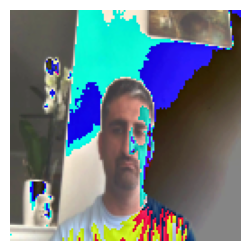

Title: Train sample
Label index: 0
--------------------------------------------------
Random TEST sample:


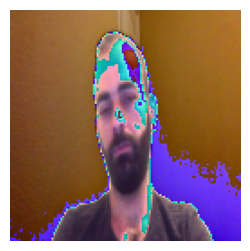

Title: Test sample
Label index: 1
--------------------------------------------------


In [7]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_random_sample_from_subset(subset, title):
    # subset is a torch.utils.data.Subset
    # subset.dataset is the underlying ImageFolder
    # subset.indices is the list of indices into the ImageFolder

    # pick a random index inside the subset
    subset_idx = random.randint(0, len(subset) - 1)
    # real_idx = subset.indices[subset_idx]   # index inside ImageFolder

    # get image + label
    img, label = subset[subset_idx]

    # get file path
    # filepath, _ = subset.dataset.samples[real_idx]

    # convert tensor to PIL for display
    img_pil = F.to_pil_image(img)

    plt.figure(figsize=(3, 3))
    plt.imshow(img_pil)
    # plt.title(f"{title}\nLabel: {subset.dataset.classes[label]}")
    plt.axis("off")
    plt.show()

    # also print details in text
    print(f"Title: {title}")
    print(f"Label index: {label}")
    # print(f"Label name: {subset.dataset.classes[label]}")
    # print(f"File path: {filepath}")
    print("--------------------------------------------------")


print("Random TRAIN sample:")
show_random_sample_from_subset(train_quantized_dataset, "Train sample")

print("Random TEST sample:")
show_random_sample_from_subset(test_quantized_dataset, "Test sample")


In [8]:
from torch.utils.data import DataLoader

batch_size = 16   # safer for larger images; adjust later if needed

train_quantized_loader = DataLoader(
    train_quantized_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,      # try 4; reduce to 0 if errors
    pin_memory=False
)

test_quantized_loader = DataLoader(
    test_quantized_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

val_quantized_loader = DataLoader(
    val_quantized_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

In [9]:
count = 0
for x, y in train_quantized_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        break

Input shape for 1 batch: torch.Size([16, 3, 128, 128])
Label shape for 1 batch: torch.Size([16])


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

Target device: cpu


In [11]:
num_classes = len(full_dataset.classes) 
print("Number of classes:", num_classes, "->", full_dataset.classes)

Number of classes: 2 -> ['active', 'fatigue']


In [12]:
#### MODEL 6 #### 

from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN(nn.Module):
    """
    Lighter version of the Keras-style model:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Flatten -> Dropout(0.5) -> Dense(32) -> Dense(num_classes)
    """

    def __init__(self, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()

        # --------- Block 1: 3 -> 16 ---------
        self.conv1 = QuantConv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool1 = nn.MaxPool2d(2, 2)   # H,W: 128 -> 64

        # --------- Block 2: 16 -> 32 ---------
        self.conv2 = QuantConv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act2 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool2 = nn.MaxPool2d(2, 2)   # 64 -> 32

        # --------- Block 3: 32 -> 32 ---------
        self.conv3 = QuantConv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act3 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool3 = nn.MaxPool2d(2, 2)   # 32 -> 16

        # --------- Block 4: 32 -> 32 ---------
        self.conv4 = QuantConv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act4 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool4 = nn.MaxPool2d(2, 2)   # 16 -> 8

        # --------- Compute feature_dim automatically ---------
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]   # should be 32 * 8 * 8 = 2048 for 128x128

        # --------- Dropout + FC layers ---------
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = QuantLinear(
            in_features=self.feature_dim,
            out_features=32,   # smaller hidden layer
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act_fc1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )

        self.fc2 = QuantLinear(
            in_features=32,
            out_features=num_classes,   # 2 for drowsy/active
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)   # flatten
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.fc2(x)             # logits
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=input_h,
#     input_width=input_w,
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)

In [13]:
#############################
######## MODEL 6.1 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_1(nn.Module):
    """
    Model 6.1:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Flatten -> Dropout(0.3) -> FC(64) -> ReLU -> Dropout(0.3) -> FC(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3: 32 -> 32, 32 -> 16
        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 4: 32 -> 32, 16 -> 8
        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        # feature dim
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # for 128: 32*8*8 = 2048

        # Head
        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_1(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model.name)
# print("feature_dim:", model.feature_dim)


In [14]:
#############################
######## MODEL 6.2 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_2(nn.Module):
    """
    Model 6.2:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(48) + MaxPool
      Conv(64) + MaxPool
      Flatten -> Dropout(0.3) -> FC(64) -> ReLU -> Dropout(0.3) -> FC(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3: 32 -> 48, 32 -> 16
        self.conv3 = QuantConv2d(32, 48, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 4: 48 -> 64, 16 -> 8
        self.conv4 = QuantConv2d(48, 64, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 64*8*8 = 4096

        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_2(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)


In [15]:
#############################
######## MODEL 6.3 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_3(nn.Module):
    """
    Model 6.3:
      Same as Model 6 conv widths, but adds Dropout2d(p=0.1) in the conv trunk
      (training-only) + head like 6.1.
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Dropout2d in trunk (training-only)
        self.drop2 = nn.Dropout2d(p=0.1)

        # Block 3: 32 -> 32, 32 -> 16
        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.drop3 = nn.Dropout2d(p=0.1)

        # Block 4: 32 -> 32, 16 -> 8
        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.drop2(x)
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.drop3(x)
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*8*8 = 2048

        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.drop3(x)
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_3(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)


In [16]:
### Model 8 ### 

from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class Model8_Bottleneck1x1(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Block 1: 3 -> 16 -> (1x1) -> 8, pool
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.conv1b = QuantConv2d(16, 8, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                  weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1b  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)  # 128->64

        # Block 2: 8 -> 16 -> (1x1) -> 16, pool
        self.conv2 = QuantConv2d(8, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.conv2b = QuantConv2d(16, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                  weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2b  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)  # 64->32

        # Block 3: 16 -> 32, pool
        self.conv3 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)  # 32->16

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1b(self.conv1b(self.act1(self.conv1(dummy)))))
            x = self.pool2(self.act2b(self.conv2b(self.act2(self.conv2(x)))))
            x = self.pool3(self.act3(self.conv3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1b(self.conv1b(self.act1(self.conv1(x)))))
        x = self.pool2(self.act2b(self.conv2b(self.act2(self.conv2(x)))))
        x = self.pool3(self.act3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [17]:
### Model 9 ### 
class Model9_VGGLite(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Stage 1: 3 -> 16 -> 16, pool (128->64)
        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c1b = QuantConv2d(16, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        # Stage 2: 16 -> 32 -> 32, pool (64->32)
        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c2b = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        # Stage 3: 32 -> 48, pool (32->16)
        self.c3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1b(self.c1b(self.a1(self.c1(dummy)))))
            x = self.p2(self.a2b(self.c2b(self.a2(self.c2(x)))))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1b(self.c1b(self.a1(self.c1(x)))))
        x = self.p2(self.a2b(self.c2b(self.a2(self.c2(x)))))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [18]:
### Model 10 ###
class Model10_MorePooling(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)  # 128->64

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)  # 64->32

        self.c3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)  # 32->16

        self.c4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 16->8

        self.c5 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a5 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p5 = nn.MaxPool2d(2,2)  # 8->4  (this is the point)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            x = self.p5(self.a5(self.c5(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*4*4 = 512

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = self.p5(self.a5(self.c5(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [19]:
### Model 11 ### 
class Model11_CappedChannels(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(24, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(24, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 128->64->32->16->8

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*8*8 = 2048

        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [20]:
### Model 12 ###

class Model12_ShrinkBeforeFC(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        
        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)  # 128->64

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)  # 64->32

        self.c3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)  # 32->16

        # 1x1 squeeze: 48 -> 16 (cheap)
        self.squeeze = QuantConv2d(48, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                   weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_sq = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 16->8

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a_sq(self.squeeze(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 16*8*8 = 1024

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a_sq(self.squeeze(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [21]:
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch


In [22]:
class Model13_VGGmini(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.conv1 = QuantConv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool1 = nn.MaxPool2d(2, 2)   # 128->64

        self.conv2 = QuantConv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act2 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool2 = nn.MaxPool2d(2, 2)   # 64->32

        self.conv3 = QuantConv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act3 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool3 = nn.MaxPool2d(2, 2)   # 32->16

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim,
            out_features=64,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act_fc1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.fc2 = QuantLinear(
            in_features=64,
            out_features=num_classes,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [23]:
class Model14_VGGmini_morepool(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)   # 128->64

        self.conv2 = QuantConv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)   # 64->32

        self.conv3 = QuantConv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)   # 32->16

        self.pool4 = nn.MaxPool2d(2, 2)   # 16->8

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [24]:
class Model15_2conv_stages(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Stage 1
        self.c11 = QuantConv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a11 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c12 = QuantConv2d(
            in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a12 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)  # 128 -> 64

        # Stage 2
        self.c21 = QuantConv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a21 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c22 = QuantConv2d(
            in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a22 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)  # 64 -> 32

        # Stage 3
        self.c31 = QuantConv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a31 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # feature_dim
        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a12(self.c12(self.a11(self.c11(d)))))
            x = self.p2(self.a22(self.c22(self.a21(self.c21(x)))))
            x = self.p3(self.a31(self.c31(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        # head
        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.p1(self.a12(self.c12(self.a11(self.c11(x)))))
        x = self.p2(self.a22(self.c22(self.a21(self.c21(x)))))
        x = self.p3(self.a31(self.c31(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)



In [25]:
class Model16_wide_early(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(
            in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(
            in_channels=24, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(
            in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.pool4 = nn.MaxPool2d(2, 2)  # -> 8x8

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [26]:
class Model17_deeper_4blocks(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = QuantConv2d(64, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(
            in_features=self.feature_dim, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [27]:
class Model18_bigger_head(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 128, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.fc2 = QuantLinear(128, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.fc3 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.act_fc2(self.fc2(x))
        return self.fc3(x)


In [28]:
class Model19_lowchan_deeper(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 12, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(12, 16, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(16, 20, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)

        self.c4 = QuantConv2d(20, 24, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [29]:
class Model20_all32(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)

        self.c4 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [30]:
class Model21_late64(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = QuantConv2d(32, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [31]:
class Model22_extra_conv_mid(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c4 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.p3 = nn.MaxPool2d(2, 2)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a3(self.c3(x))
            x = self.a4(self.c4(x))
            x = self.p3(x)
            x = self.p4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a3(self.c3(x))
        x = self.a4(self.c4(x))
        x = self.p3(x)
        x = self.p4(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [32]:
class M6_1_WiderEarly(nn.Module):
    def __init__(self, name="M6_1_WiderEarly", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.conv1 = QuantConv2d(3, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2,2)  # 128->64

        self.conv2 = QuantConv2d(24, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2,2)  # 64->32

        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2,2)  # 32->16

        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2,2)  # 16->8

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [33]:
class M6_2_StrongerLate(nn.Module):
    def __init__(self, name="M6_2_StrongerLate", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = QuantConv2d(48, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [34]:
class M6_3_ExtraConvMid(nn.Module):
    def __init__(self, name="M6_3_ExtraConvMid", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c2b = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.a2(self.c2(x))
            x = self.a2b(self.c2b(x))
            x = self.p2(x)
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.a2(self.c2(x))
        x = self.a2b(self.c2b(x))
        x = self.p2(x)
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [35]:
class M6_4_BiggerHead(nn.Module):
    def __init__(self, name="M6_4_BiggerHead", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [36]:
class M6_5_BottleneckMid(nn.Module):
    def __init__(self, name="M6_5_BottleneckMid", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        # bottleneck: 32 -> 16 (1x1), then 16 -> 32 (3x3)
        self.c2_1x1 = QuantConv2d(32, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2_1x1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c3 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a2_1x1(self.c2_1x1(x))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a2_1x1(self.c2_1x1(x))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [37]:
class M13_1_ExtraConvEarly(nn.Module):
    def __init__(self, name="M13_1_ExtraConvEarly", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1a = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1a = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c1b = QuantConv2d(16, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1  = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32, 64, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1b(self.c1b(self.a1a(self.c1a(d)))))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.c1a(x); x = self.a1a(x)
        x = self.c1b(x); x = self.a1b(x)
        x = self.p1(x)
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [38]:
class M13_2_Wider(nn.Module):
    def __init__(self, name="M13_2_Wider", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 40, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(40, 80, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [39]:
class M13_3_Extra1x1Late(nn.Module):
    def __init__(self, name="M13_3_Extra1x1Late", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32, 64, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c3b = QuantConv2d(64, 64, 1, 1, 0, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a3(self.c3(x))
            x = self.a3b(self.c3b(x))
            x = self.p3(x)
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a3(self.c3(x))
        x = self.a3b(self.c3b(x))
        x = self.p3(x)
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [40]:
class M13_4_MorePoolBiggerFC(nn.Module):
    def __init__(self, name="M13_4_MorePoolBiggerFC", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3,16,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16,32,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32,64,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.p4 = nn.MaxPool2d(2,2)  # 16->8 (reduces feature_dim)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(x)
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 128, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(128, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(x)
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [41]:
class M13_5_WithDropout(nn.Module):
    def __init__(self, name="M13_5_WithDropout", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3,16,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16,32,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32,64,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [42]:
class M19_1_SlightlyWider(nn.Module):
    def __init__(self, name="M19_1_SlightlyWider", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 14, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(14, 18, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(18, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(24, 30, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [43]:
class M19_2_LastTo32(nn.Module):
    def __init__(self, name="M19_2_LastTo32", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(16, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        return self.fc(x)


In [44]:
class M19_3_ExtraConvMid(nn.Module):
    def __init__(self, name="M19_3_ExtraConvMid", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c2b = QuantConv2d(16, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(16, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.a2(self.c2(x))
            x = self.a2b(self.c2b(x))
            x = self.p2(x)
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.a2(self.c2(x))
        x = self.a2b(self.c2b(x))
        x = self.p2(x)
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [45]:
class M19_4_BottleneckBeforeC3(nn.Module):
    def __init__(self, name="M19_4_BottleneckBeforeC3", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c2_1x1 = QuantConv2d(16, 12, 1, 1, 0, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2_1x1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c3 = QuantConv2d(12, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a2_1x1(self.c2_1x1(x))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a2_1x1(self.c2_1x1(x))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        return self.fc(x)


In [46]:
class M19_5_BiggerHead(nn.Module):
    def __init__(self, name="M19_5_BiggerHead", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(16, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc3 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = self.a_fc1(self.fc1(x))
        x = self.a_fc2(self.fc2(x))
        return self.fc3(x)


In [47]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()   
                
        # forward pass
        output = model(inputs.float())      # (batch, num_classes)
        # CrossEntropyLoss expects class indices (0..num_classes-1)
        loss = criterion(output, target.long())
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.item()) 
           
    return losses


In [48]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, target in loader:
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total


In [49]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

def run_experiment(build_model_fn, exp_name, num_epochs):
    
    model = build_model_fn(num_classes=2, w_bit= 4, a_bit = 4, input_height = 128, input_width = 128).to(device)

    print(f"Model to test: {exp_name}")

    # print(model)
    print("feature_dim:", model.feature_dim)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",          # we want to maximize val accuracy
    factor=0.5,          # multiply LR by 0.5
    patience=5,          # wait 5 epochs with no improvement
    verbose=TrueM13_4_MorePoolBiggerFC
    )
    
    print("Criterion:", criterion)
    print("Optimizer:", optimizer)
    print("Scheduler:", scheduler)

    # %%time
    # x = torch.randn(1, 3, 128, 128).to(device)
    # for i in range(100):
    #     y = model(x)
        
    # %%time
    # batch = next(iter(train_quantized_loader))

    running_loss = []
    running_val_acc = []
    
    best_val_acc = 0.0
    best_state_dict = None
    # best_epoch = -1

    t = trange(num_epochs, desc="Training", leave=True)
    
    for epoch in t:
        
        # --- TRAIN ---
        epoch_losses = train(model, train_quantized_loader, optimizer, criterion)
        train_loss = float(np.mean(epoch_losses))

        # --- VALIDATE ---
        val_acc = evaluate(model, val_quantized_loader, device)

        # LR scheduler (based on validation accuracy)
        scheduler.step(val_acc)

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        running_loss.append(train_loss)
        running_val_acc.append(val_acc)

        t.set_description(
            f"Epoch {epoch+1}/{num_epochs} loss={train_loss:.4f} val_acc={val_acc:.4f} "
            f"best={best_val_acc:.4f}"
        )
        t.refresh()

    print("Best val accuracy:", best_val_acc)

    # Restore best model (optional but usually a good idea)
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)
        
    test_acc = evaluate(model, test_quantized_loader, device)
    print("Final TEST accuracy:", test_acc)

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(range(1, len(running_val_acc) + 1), running_loss, color="tab:blue", label="Training loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.plot(range(1, len(running_val_acc) + 1), running_val_acc, color="tab:orange", marker='o', label="Validation accuracy")
    ax2.set_ylabel("Accuracy", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    
    fig.suptitle(exp_name)
    fig.tight_layout()
    plt.show()
    
    del model, optimizer, scheduler
    import gc
    gc.collect()
    torch.cuda.empty_cache()

In [50]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def run_experiment_new(
    build_model_fn,
    exp_name,
    num_epochs,
    *,
    lr=1e-3,
    weight_decay=1e-4,
    batch_size=None,          # just for logging, since loaders already built
    patience=5,
    factor=0.5,
    min_lr=1e-6,
    seed=0,
):
    # reproducibility per experiment
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = build_model_fn(num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128).to(device)

    print(f"\nModel to test: {exp_name}")
    print("feature_dim:", getattr(model, "feature_dim", "N/A"))
    print(f"lr={lr} wd={weight_decay} patience={patience} factor={factor} min_lr={min_lr} seed={seed} batch={batch_size}")

    criterion = nn.CrossEntropyLoss().to(device)

    # AdamW is often more predictable than Adam when you use weight_decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=factor,
        patience=patience,
        min_lr=min_lr,
        verbose=True
    )

    running_loss = []
    running_val_acc = []
    best_val_acc = 0.0
    best_state_dict = None

    t = trange(num_epochs, desc="Training", leave=True)

    for epoch in t:
        epoch_losses = train(model, train_quantized_loader, optimizer, criterion)
        train_loss = float(np.mean(epoch_losses))

        val_acc = evaluate(model, val_quantized_loader, device)
        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        running_loss.append(train_loss)
        running_val_acc.append(val_acc)

        t.set_description(
            f"Epoch {epoch+1}/{num_epochs} loss={train_loss:.4f} val_acc={val_acc:.4f} best={best_val_acc:.4f}"
        )

    print("Best val accuracy:", best_val_acc)

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)

    test_acc = evaluate(model, test_quantized_loader, device)
    print("Final TEST accuracy:", test_acc)

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(range(1, len(running_val_acc) + 1), running_loss, color="tab:blue", label="Training loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(range(1, len(running_val_acc) + 1), running_val_acc, color="tab:orange", marker='o', label="Validation accuracy")
    ax2.set_ylabel("Accuracy", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    fig.suptitle(exp_name)
    fig.tight_layout()
    plt.show()

    del model, optimizer, scheduler
    import gc
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return best_val_acc, test_acc


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)



Model to test: Model_13 LR: 1e-3, WD: 0, Patience: 2
feature_dim: 16384
lr=0.001 wd=0 patience=2 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 16/100 loss=0.5443 val_acc=0.6886 best=0.7621:  16%|▏| 16/100 [25:45<2:12:

Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 20/100 loss=0.5368 val_acc=0.7133 best=0.7654:  20%|▏| 20/100 [32:18<2:07:

Epoch 00020: reducing learning rate of group 0 to 2.5000e-04.


Epoch 27/100 loss=0.5331 val_acc=0.7144 best=0.7939:  27%|▎| 27/100 [43:34<2:00:

Epoch 00027: reducing learning rate of group 0 to 1.2500e-04.


Epoch 31/100 loss=0.5295 val_acc=0.7166 best=0.8026:  31%|▎| 31/100 [50:19<1:55:

Epoch 00031: reducing learning rate of group 0 to 6.2500e-05.


Epoch 34/100 loss=0.5279 val_acc=0.7275 best=0.8026:  34%|▎| 34/100 [55:31<1:52:

Epoch 00034: reducing learning rate of group 0 to 3.1250e-05.


Epoch 37/100 loss=0.5278 val_acc=0.7303 best=0.8026:  37%|▎| 37/100 [1:00:39<1:4

Epoch 00037: reducing learning rate of group 0 to 1.5625e-05.


Epoch 40/100 loss=0.5250 val_acc=0.7330 best=0.8026:  40%|▍| 40/100 [1:05:46<1:4

Epoch 00040: reducing learning rate of group 0 to 7.8125e-06.


Epoch 43/100 loss=0.5256 val_acc=0.7314 best=0.8026:  43%|▍| 43/100 [1:10:54<1:3

Epoch 00043: reducing learning rate of group 0 to 3.9063e-06.


Epoch 46/100 loss=0.5241 val_acc=0.7341 best=0.8026:  46%|▍| 46/100 [1:16:02<1:3

Epoch 00046: reducing learning rate of group 0 to 1.9531e-06.


Epoch 49/100 loss=0.5239 val_acc=0.7352 best=0.8026:  49%|▍| 49/100 [1:21:10<1:2

Epoch 00049: reducing learning rate of group 0 to 9.7656e-07.


Epoch 52/100 loss=0.5256 val_acc=0.7325 best=0.8026:  52%|▌| 52/100 [1:26:20<1:2

Epoch 00052: reducing learning rate of group 0 to 4.8828e-07.


Epoch 55/100 loss=0.5243 val_acc=0.7341 best=0.8026:  55%|▌| 55/100 [1:31:32<1:1

Epoch 00055: reducing learning rate of group 0 to 2.4414e-07.


Epoch 58/100 loss=0.5252 val_acc=0.7341 best=0.8026:  58%|▌| 58/100 [1:36:40<1:1

Epoch 00058: reducing learning rate of group 0 to 1.2207e-07.


Epoch 61/100 loss=0.5241 val_acc=0.7341 best=0.8026:  61%|▌| 61/100 [1:41:55<1:0

Epoch 00061: reducing learning rate of group 0 to 6.1035e-08.


Epoch 64/100 loss=0.5249 val_acc=0.7341 best=0.8026:  64%|▋| 64/100 [1:47:14<1:0

Epoch 00064: reducing learning rate of group 0 to 3.0518e-08.


Epoch 67/100 loss=0.5253 val_acc=0.7341 best=0.8026:  67%|▋| 67/100 [1:52:27<57:

Epoch 00067: reducing learning rate of group 0 to 1.5259e-08.


Epoch 100/100 loss=0.5244 val_acc=0.7325 best=0.8026: 100%|█| 100/100 [2:49:33<0

Best val accuracy: 0.8026315789473685


Final TEST accuracy: 0.8074807480748075


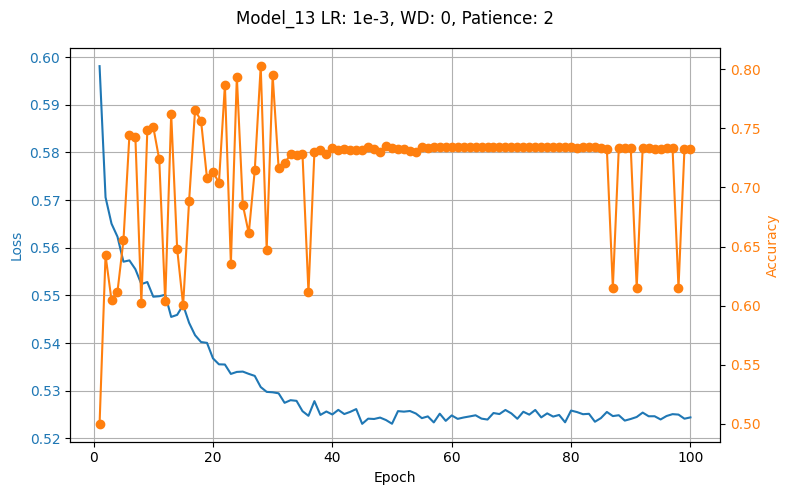


Model to test: Model_13 LR: 1e-3, WD: 1e-5, Patience: 2
feature_dim: 16384
lr=0.001 wd=1e-05 patience=2 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 16/100 loss=0.5443 val_acc=0.6886 best=0.7621:  16%|▏| 16/100 [29:23<2:33:

Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 20/100 loss=0.5368 val_acc=0.7133 best=0.7654:  20%|▏| 20/100 [36:30<2:23:

Epoch 00020: reducing learning rate of group 0 to 2.5000e-04.


Epoch 27/100 loss=0.5331 val_acc=0.7144 best=0.7939:  27%|▎| 27/100 [48:52<2:11:

Epoch 00027: reducing learning rate of group 0 to 1.2500e-04.


Epoch 31/100 loss=0.5295 val_acc=0.7166 best=0.8026:  31%|▎| 31/100 [56:23<2:06:

Epoch 00031: reducing learning rate of group 0 to 6.2500e-05.


Epoch 34/100 loss=0.5279 val_acc=0.7275 best=0.8026:  34%|▎| 34/100 [1:01:54<2:0

Epoch 00034: reducing learning rate of group 0 to 3.1250e-05.


Epoch 37/100 loss=0.5278 val_acc=0.7303 best=0.8026:  37%|▎| 37/100 [1:07:54<2:0

Epoch 00037: reducing learning rate of group 0 to 1.5625e-05.


Epoch 40/100 loss=0.5250 val_acc=0.7330 best=0.8026:  40%|▍| 40/100 [1:13:50<1:5

Epoch 00040: reducing learning rate of group 0 to 7.8125e-06.


Epoch 43/100 loss=0.5256 val_acc=0.7314 best=0.8026:  43%|▍| 43/100 [1:19:46<1:5

Epoch 00043: reducing learning rate of group 0 to 3.9063e-06.


Epoch 46/100 loss=0.5241 val_acc=0.7341 best=0.8026:  46%|▍| 46/100 [1:24:55<1:3

Epoch 00046: reducing learning rate of group 0 to 1.9531e-06.


Epoch 49/100 loss=0.5239 val_acc=0.7352 best=0.8026:  49%|▍| 49/100 [1:29:58<1:2

Epoch 00049: reducing learning rate of group 0 to 9.7656e-07.


Epoch 52/100 loss=0.5256 val_acc=0.7325 best=0.8026:  52%|▌| 52/100 [1:35:15<1:2

Epoch 00052: reducing learning rate of group 0 to 4.8828e-07.


Epoch 55/100 loss=0.5243 val_acc=0.7341 best=0.8026:  55%|▌| 55/100 [1:40:15<1:1

Epoch 00055: reducing learning rate of group 0 to 2.4414e-07.


Epoch 58/100 loss=0.5252 val_acc=0.7341 best=0.8026:  58%|▌| 58/100 [1:45:49<1:1

Epoch 00058: reducing learning rate of group 0 to 1.2207e-07.


Epoch 61/100 loss=0.5241 val_acc=0.7341 best=0.8026:  61%|▌| 61/100 [1:51:13<1:1

Epoch 00061: reducing learning rate of group 0 to 6.1035e-08.


Epoch 64/100 loss=0.5249 val_acc=0.7341 best=0.8026:  64%|▋| 64/100 [1:56:41<1:0

Epoch 00064: reducing learning rate of group 0 to 3.0518e-08.


Epoch 67/100 loss=0.5253 val_acc=0.7341 best=0.8026:  67%|▋| 67/100 [2:02:07<59:

Epoch 00067: reducing learning rate of group 0 to 1.5259e-08.


Epoch 100/100 loss=0.5244 val_acc=0.7325 best=0.8026: 100%|█| 100/100 [3:01:30<0

Best val accuracy: 0.8026315789473685


Final TEST accuracy: 0.8074807480748075


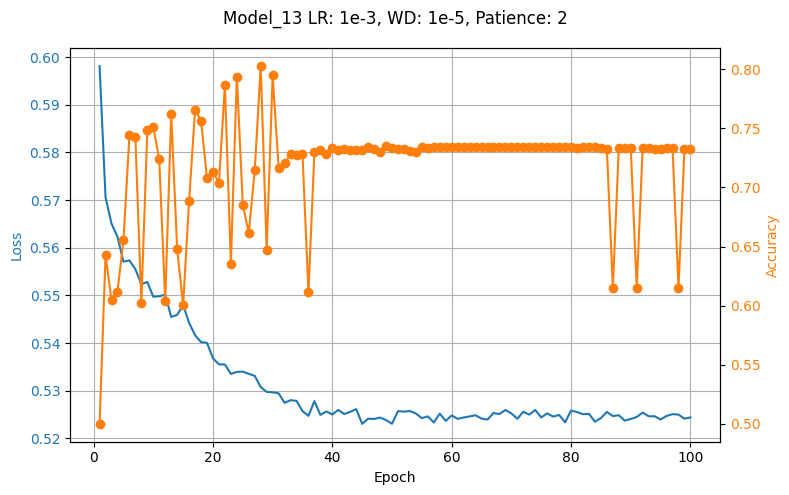


Model to test: Model_13 LR: 1e-3, WD: 5e-5, Patience: 2
feature_dim: 16384
lr=0.001 wd=5e-05 patience=2 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 9/100 loss=0.5513 val_acc=0.6705 best=0.7637:   9%| | 9/100 [16:14<2:41:07

Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.


Epoch 12/100 loss=0.5405 val_acc=0.6809 best=0.7637:  12%| | 12/100 [21:39<2:37:

Epoch 00012: reducing learning rate of group 0 to 2.5000e-04.


Epoch 15/100 loss=0.5351 val_acc=0.7429 best=0.7637:  15%|▏| 15/100 [27:00<2:32:

Epoch 00015: reducing learning rate of group 0 to 1.2500e-04.


Epoch 18/100 loss=0.5321 val_acc=0.6711 best=0.7637:  18%|▏| 18/100 [32:32<2:29:

Epoch 00018: reducing learning rate of group 0 to 6.2500e-05.


Epoch 21/100 loss=0.5300 val_acc=0.7467 best=0.7637:  21%|▏| 21/100 [38:01<2:23:

Epoch 00021: reducing learning rate of group 0 to 3.1250e-05.


Epoch 24/100 loss=0.5290 val_acc=0.7511 best=0.7637:  24%|▏| 24/100 [43:21<2:16:

Epoch 00024: reducing learning rate of group 0 to 1.5625e-05.


Epoch 27/100 loss=0.5275 val_acc=0.6820 best=0.7637:  27%|▎| 27/100 [48:43<2:10:

Epoch 00027: reducing learning rate of group 0 to 7.8125e-06.


Epoch 30/100 loss=0.5280 val_acc=0.7549 best=0.7637:  30%|▎| 30/100 [54:17<2:08:

Epoch 00030: reducing learning rate of group 0 to 3.9063e-06.


Epoch 33/100 loss=0.5269 val_acc=0.6804 best=0.7637:  33%|▎| 33/100 [59:49<2:02:

Epoch 00033: reducing learning rate of group 0 to 1.9531e-06.


Epoch 36/100 loss=0.5261 val_acc=0.6782 best=0.7637:  36%|▎| 36/100 [1:05:18<1:5

Epoch 00036: reducing learning rate of group 0 to 9.7656e-07.


Epoch 39/100 loss=0.5259 val_acc=0.6837 best=0.7637:  39%|▍| 39/100 [1:10:45<1:5

Epoch 00039: reducing learning rate of group 0 to 4.8828e-07.


Epoch 42/100 loss=0.5279 val_acc=0.7511 best=0.7637:  42%|▍| 42/100 [1:16:10<1:4

Epoch 00042: reducing learning rate of group 0 to 2.4414e-07.


Epoch 45/100 loss=0.5263 val_acc=0.6848 best=0.7637:  45%|▍| 45/100 [1:21:30<1:3

Epoch 00045: reducing learning rate of group 0 to 1.2207e-07.


Epoch 48/100 loss=0.5278 val_acc=0.6853 best=0.7637:  48%|▍| 48/100 [1:26:55<1:3

Epoch 00048: reducing learning rate of group 0 to 6.1035e-08.


Epoch 51/100 loss=0.5286 val_acc=0.6848 best=0.7637:  51%|▌| 51/100 [1:32:19<1:2

Epoch 00051: reducing learning rate of group 0 to 3.0518e-08.


Epoch 54/100 loss=0.5271 val_acc=0.6853 best=0.7637:  54%|▌| 54/100 [1:37:39<1:2

Epoch 00054: reducing learning rate of group 0 to 1.5259e-08.


Epoch 100/100 loss=0.5272 val_acc=0.7527 best=0.7637: 100%|█| 100/100 [3:00:19<0

Best val accuracy: 0.7637061403508771


Final TEST accuracy: 0.768976897689769


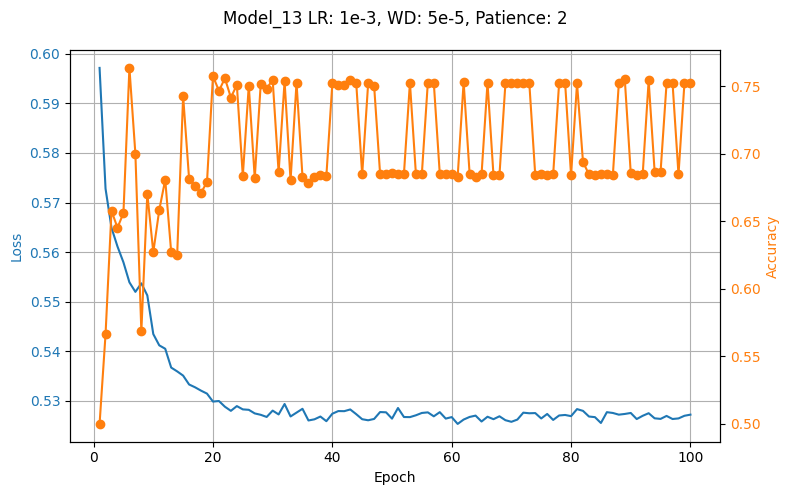


Model to test: Model_13 LR: 1e-3, WD: 1e-4, Patience: 2
feature_dim: 16384
lr=0.001 wd=0.0001 patience=2 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 5/100 loss=0.5588 val_acc=0.5839 best=0.6546:   5%| | 5/100 [08:54<2:46:37

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.


Epoch 12/100 loss=0.5418 val_acc=0.6491 best=0.7379:  12%| | 12/100 [21:10<2:32:

Epoch 00012: reducing learning rate of group 0 to 2.5000e-04.


Epoch 15/100 loss=0.5361 val_acc=0.6250 best=0.7379:  15%|▏| 15/100 [25:42<2:15:

Epoch 00015: reducing learning rate of group 0 to 1.2500e-04.


Epoch 18/100 loss=0.5317 val_acc=0.6442 best=0.7379:  18%|▏| 18/100 [30:57<2:18:

Epoch 00018: reducing learning rate of group 0 to 6.2500e-05.


Epoch 21/100 loss=0.5282 val_acc=0.6557 best=0.7379:  21%|▏| 21/100 [35:27<2:02:

Epoch 00021: reducing learning rate of group 0 to 3.1250e-05.


Epoch 24/100 loss=0.5275 val_acc=0.6557 best=0.7379:  24%|▏| 24/100 [40:41<2:08:

Epoch 00024: reducing learning rate of group 0 to 1.5625e-05.


Epoch 27/100 loss=0.5258 val_acc=0.6557 best=0.7379:  27%|▎| 27/100 [45:59<2:06:

Epoch 00027: reducing learning rate of group 0 to 7.8125e-06.


Epoch 30/100 loss=0.5276 val_acc=0.6590 best=0.7379:  30%|▎| 30/100 [51:18<2:03:

Epoch 00030: reducing learning rate of group 0 to 3.9063e-06.


Epoch 33/100 loss=0.5261 val_acc=0.6573 best=0.7379:  33%|▎| 33/100 [56:46<2:01:

Epoch 00033: reducing learning rate of group 0 to 1.9531e-06.


Epoch 36/100 loss=0.5262 val_acc=0.6579 best=0.7379:  36%|▎| 36/100 [1:02:13<1:5

Epoch 00036: reducing learning rate of group 0 to 9.7656e-07.


Epoch 39/100 loss=0.5253 val_acc=0.6601 best=0.7379:  39%|▍| 39/100 [1:07:21<1:4

Epoch 00039: reducing learning rate of group 0 to 4.8828e-07.


Epoch 42/100 loss=0.5265 val_acc=0.6595 best=0.7379:  42%|▍| 42/100 [1:12:23<1:3

Epoch 00042: reducing learning rate of group 0 to 2.4414e-07.


Epoch 45/100 loss=0.5250 val_acc=0.6590 best=0.7379:  45%|▍| 45/100 [1:18:06<1:4

Epoch 00045: reducing learning rate of group 0 to 1.2207e-07.


Epoch 48/100 loss=0.5261 val_acc=0.6584 best=0.7379:  48%|▍| 48/100 [1:23:05<1:2

Epoch 00048: reducing learning rate of group 0 to 6.1035e-08.


Epoch 51/100 loss=0.5276 val_acc=0.6590 best=0.7379:  51%|▌| 51/100 [1:28:55<1:3

Epoch 00051: reducing learning rate of group 0 to 3.0518e-08.


Epoch 54/100 loss=0.5270 val_acc=0.6590 best=0.7379:  54%|▌| 54/100 [1:34:38<1:2

Epoch 00054: reducing learning rate of group 0 to 1.5259e-08.


Epoch 100/100 loss=0.5257 val_acc=0.6672 best=0.7379: 100%|█| 100/100 [3:03:08<0

Best val accuracy: 0.7379385964912281


Final TEST accuracy: 0.7238723872387238


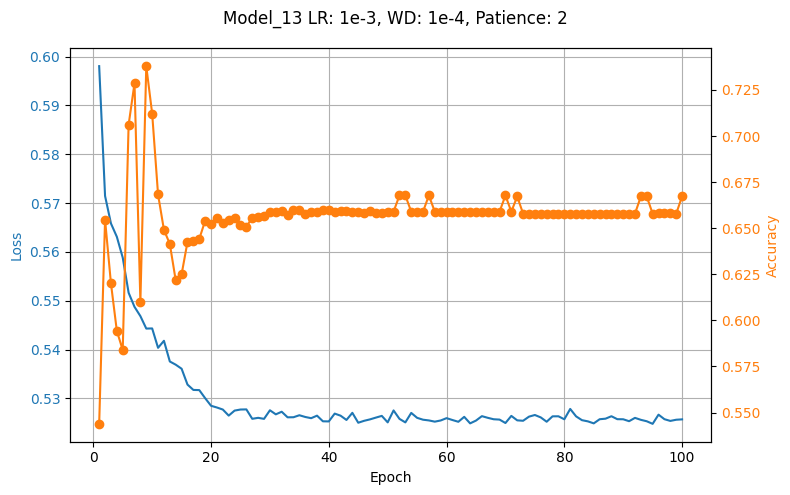


Model to test: Model_13 LR: 1e-3, WD: 5e-4, Patience: 2
feature_dim: 16384
lr=0.001 wd=0.0005 patience=2 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 12/100 loss=0.5488 val_acc=0.5724 best=0.7549:  12%| | 12/100 [24:25<2:57:

Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/100 loss=0.5414 val_acc=0.6305 best=0.7549:  15%|▏| 15/100 [30:27<2:50:

Epoch 00015: reducing learning rate of group 0 to 2.5000e-04.


Epoch 18/100 loss=0.5350 val_acc=0.6913 best=0.7549:  18%|▏| 18/100 [36:28<2:44:

Epoch 00018: reducing learning rate of group 0 to 1.2500e-04.


Epoch 24/100 loss=0.5311 val_acc=0.7034 best=0.7681:  24%|▏| 24/100 [48:30<2:31:

Epoch 00024: reducing learning rate of group 0 to 6.2500e-05.


Epoch 27/100 loss=0.5290 val_acc=0.6963 best=0.7681:  27%|▎| 27/100 [54:34<2:27:

Epoch 00027: reducing learning rate of group 0 to 3.1250e-05.


Epoch 30/100 loss=0.5283 val_acc=0.6990 best=0.7681:  30%|▎| 30/100 [1:00:36<2:2

Epoch 00030: reducing learning rate of group 0 to 1.5625e-05.


Epoch 33/100 loss=0.5263 val_acc=0.7007 best=0.7681:  33%|▎| 33/100 [1:06:37<2:1

Epoch 00033: reducing learning rate of group 0 to 7.8125e-06.


Epoch 36/100 loss=0.5253 val_acc=0.7001 best=0.7681:  36%|▎| 36/100 [1:12:44<2:0

Epoch 00036: reducing learning rate of group 0 to 3.9063e-06.


Epoch 39/100 loss=0.5268 val_acc=0.7029 best=0.7681:  39%|▍| 39/100 [1:18:43<2:0

Epoch 00039: reducing learning rate of group 0 to 1.9531e-06.


Epoch 42/100 loss=0.5261 val_acc=0.6321 best=0.7681:  42%|▍| 42/100 [1:24:43<1:5

Epoch 00042: reducing learning rate of group 0 to 9.7656e-07.


Epoch 45/100 loss=0.5255 val_acc=0.6288 best=0.7681:  45%|▍| 45/100 [1:30:53<1:5

Epoch 00045: reducing learning rate of group 0 to 4.8828e-07.


Epoch 48/100 loss=0.5273 val_acc=0.6316 best=0.7681:  48%|▍| 48/100 [1:36:50<1:4

Epoch 00048: reducing learning rate of group 0 to 2.4414e-07.


Epoch 51/100 loss=0.5270 val_acc=0.7045 best=0.7681:  51%|▌| 51/100 [1:42:52<1:3

Epoch 00051: reducing learning rate of group 0 to 1.2207e-07.


Epoch 54/100 loss=0.5266 val_acc=0.7045 best=0.7681:  54%|▌| 54/100 [1:48:57<1:3

Epoch 00054: reducing learning rate of group 0 to 6.1035e-08.


Epoch 57/100 loss=0.5258 val_acc=0.6321 best=0.7681:  57%|▌| 57/100 [1:55:04<1:2

Epoch 00057: reducing learning rate of group 0 to 3.0518e-08.


Epoch 60/100 loss=0.5255 val_acc=0.6321 best=0.7681:  60%|▌| 60/100 [2:01:11<1:2

Epoch 00060: reducing learning rate of group 0 to 1.5259e-08.


Epoch 100/100 loss=0.5262 val_acc=0.6316 best=0.7681: 100%|█| 100/100 [3:22:00<0

Best val accuracy: 0.7680921052631579


Final TEST accuracy: 0.7766776677667767


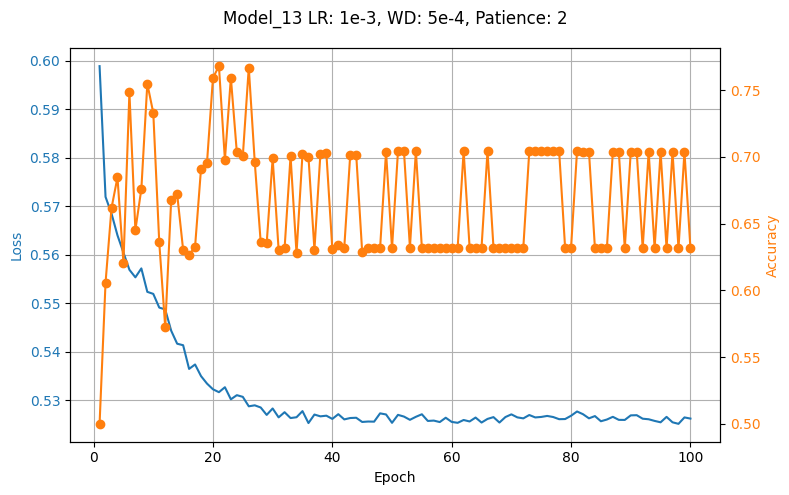


Model to test: Model_13 LR: 1e-3, WD: 0, Patience: 5
feature_dim: 16384
lr=0.001 wd=0 patience=5 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 19/100 loss=0.5476 val_acc=0.7456 best=0.7621:  19%|▏| 19/100 [37:56<2:40:

Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Epoch 38/100 loss=0.5286 val_acc=0.7928 best=0.7999:  38%|▍| 38/100 [1:15:33<2:0

Epoch 00038: reducing learning rate of group 0 to 2.5000e-04.


Epoch 48/100 loss=0.5230 val_acc=0.6036 best=0.8026:  48%|▍| 48/100 [1:35:21<1:4

Epoch 00048: reducing learning rate of group 0 to 1.2500e-04.


Epoch 54/100 loss=0.5204 val_acc=0.7917 best=0.8026:  54%|▌| 54/100 [1:47:21<1:3

Epoch 00054: reducing learning rate of group 0 to 6.2500e-05.


Epoch 60/100 loss=0.5170 val_acc=0.7840 best=0.8026:  60%|▌| 60/100 [1:59:12<1:1

Epoch 00060: reducing learning rate of group 0 to 3.1250e-05.


Epoch 66/100 loss=0.5157 val_acc=0.7549 best=0.8026:  66%|▋| 66/100 [2:11:04<1:0

Epoch 00066: reducing learning rate of group 0 to 1.5625e-05.


Epoch 72/100 loss=0.5161 val_acc=0.7911 best=0.8026:  72%|▋| 72/100 [2:23:04<55:

Epoch 00072: reducing learning rate of group 0 to 7.8125e-06.


Epoch 78/100 loss=0.5135 val_acc=0.6552 best=0.8026:  78%|▊| 78/100 [2:35:03<43:

Epoch 00078: reducing learning rate of group 0 to 3.9063e-06.


Epoch 84/100 loss=0.5148 val_acc=0.6376 best=0.8026:  84%|▊| 84/100 [2:47:09<32:

Epoch 00084: reducing learning rate of group 0 to 1.9531e-06.


Epoch 90/100 loss=0.5156 val_acc=0.7950 best=0.8026:  90%|▉| 90/100 [2:59:02<19:

Epoch 00090: reducing learning rate of group 0 to 9.7656e-07.


Epoch 96/100 loss=0.5161 val_acc=0.7939 best=0.8026:  96%|▉| 96/100 [3:10:58<07:

Epoch 00096: reducing learning rate of group 0 to 4.8828e-07.


Epoch 100/100 loss=0.5146 val_acc=0.7955 best=0.8026: 100%|█| 100/100 [3:18:54<0

Best val accuracy: 0.8026315789473685


Final TEST accuracy: 0.7898789878987899


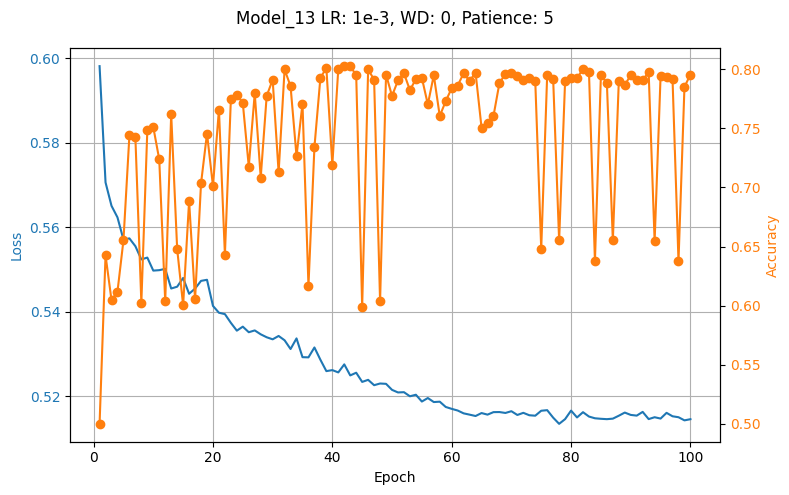


Model to test: Model_13 LR: 1e-3, WD: 1e-5, Patience: 5
feature_dim: 16384
lr=0.001 wd=1e-05 patience=5 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 19/100 loss=0.5476 val_acc=0.7456 best=0.7621:  19%|▏| 19/100 [38:22<2:41:

Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Epoch 38/100 loss=0.5286 val_acc=0.7928 best=0.7999:  38%|▍| 38/100 [1:16:31<2:0

Epoch 00038: reducing learning rate of group 0 to 2.5000e-04.


Epoch 48/100 loss=0.5230 val_acc=0.6036 best=0.8026:  48%|▍| 48/100 [1:36:21<1:4

Epoch 00048: reducing learning rate of group 0 to 1.2500e-04.


Epoch 54/100 loss=0.5204 val_acc=0.7917 best=0.8026:  54%|▌| 54/100 [1:48:25<1:3

Epoch 00054: reducing learning rate of group 0 to 6.2500e-05.


Epoch 60/100 loss=0.5170 val_acc=0.7840 best=0.8026:  60%|▌| 60/100 [2:00:24<1:1

Epoch 00060: reducing learning rate of group 0 to 3.1250e-05.


Epoch 66/100 loss=0.5157 val_acc=0.7549 best=0.8026:  66%|▋| 66/100 [2:11:31<1:0

Epoch 00066: reducing learning rate of group 0 to 1.5625e-05.


Epoch 72/100 loss=0.5161 val_acc=0.7911 best=0.8026:  72%|▋| 72/100 [2:22:16<50:

Epoch 00072: reducing learning rate of group 0 to 7.8125e-06.


Epoch 78/100 loss=0.5135 val_acc=0.6552 best=0.8026:  78%|▊| 78/100 [2:33:43<41:

Epoch 00078: reducing learning rate of group 0 to 3.9063e-06.


Epoch 84/100 loss=0.5148 val_acc=0.6376 best=0.8026:  84%|▊| 84/100 [2:45:15<30:

Epoch 00084: reducing learning rate of group 0 to 1.9531e-06.


Epoch 90/100 loss=0.5156 val_acc=0.7950 best=0.8026:  90%|▉| 90/100 [2:56:47<19:

Epoch 00090: reducing learning rate of group 0 to 9.7656e-07.


Epoch 96/100 loss=0.5161 val_acc=0.7939 best=0.8026:  96%|▉| 96/100 [3:08:27<07:

Epoch 00096: reducing learning rate of group 0 to 4.8828e-07.


Epoch 100/100 loss=0.5146 val_acc=0.7955 best=0.8026: 100%|█| 100/100 [3:16:11<0

Best val accuracy: 0.8026315789473685


Final TEST accuracy: 0.7898789878987899


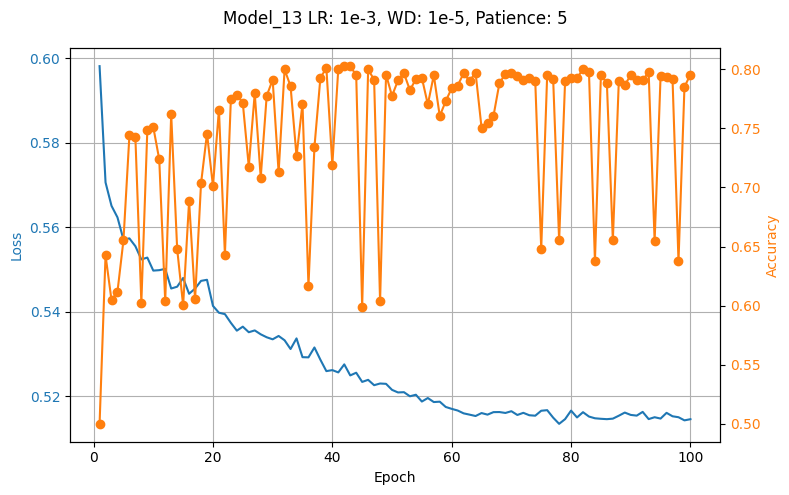


Model to test: Model_13 LR: 1e-3, WD: 5e-5, Patience: 5
feature_dim: 16384
lr=0.001 wd=5e-05 patience=5 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 12/100 loss=0.5445 val_acc=0.6497 best=0.7637:  12%| | 12/100 [22:27<2:36:

Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/100 loss=0.5356 val_acc=0.7303 best=0.7637:  18%|▏| 18/100 [32:43<2:21:

Epoch 00018: reducing learning rate of group 0 to 2.5000e-04.


Epoch 26/100 loss=0.5278 val_acc=0.7533 best=0.7686:  26%|▎| 26/100 [46:44<2:09:

Epoch 00026: reducing learning rate of group 0 to 1.2500e-04.


Epoch 38/100 loss=0.5209 val_acc=0.7007 best=0.7823:  38%|▍| 38/100 [1:07:46<1:4

Epoch 00038: reducing learning rate of group 0 to 6.2500e-05.


Epoch 53/100 loss=0.5145 val_acc=0.7812 best=0.7911:  53%|▌| 53/100 [1:34:09<1:2

Epoch 00053: reducing learning rate of group 0 to 3.1250e-05.


Epoch 59/100 loss=0.5141 val_acc=0.7703 best=0.7911:  59%|▌| 59/100 [1:44:32<1:1

Epoch 00059: reducing learning rate of group 0 to 1.5625e-05.


Epoch 65/100 loss=0.5131 val_acc=0.7829 best=0.7911:  65%|▋| 65/100 [1:55:00<1:0

Epoch 00065: reducing learning rate of group 0 to 7.8125e-06.


Epoch 71/100 loss=0.5133 val_acc=0.7845 best=0.7911:  71%|▋| 71/100 [2:05:24<50:

Epoch 00071: reducing learning rate of group 0 to 3.9063e-06.


Epoch 77/100 loss=0.5125 val_acc=0.7072 best=0.7911:  77%|▊| 77/100 [2:16:12<41:

Epoch 00077: reducing learning rate of group 0 to 1.9531e-06.


Epoch 83/100 loss=0.5131 val_acc=0.7078 best=0.7911:  83%|▊| 83/100 [2:26:47<29:

Epoch 00083: reducing learning rate of group 0 to 9.7656e-07.


Epoch 89/100 loss=0.5130 val_acc=0.7834 best=0.7911:  89%|▉| 89/100 [2:37:31<19:

Epoch 00089: reducing learning rate of group 0 to 4.8828e-07.


Epoch 95/100 loss=0.5126 val_acc=0.7078 best=0.7911:  95%|▉| 95/100 [2:48:04<08:

Epoch 00095: reducing learning rate of group 0 to 2.4414e-07.


Epoch 100/100 loss=0.5121 val_acc=0.7862 best=0.7911: 100%|█| 100/100 [2:56:48<0

Best val accuracy: 0.7911184210526315


Final TEST accuracy: 0.7832783278327833


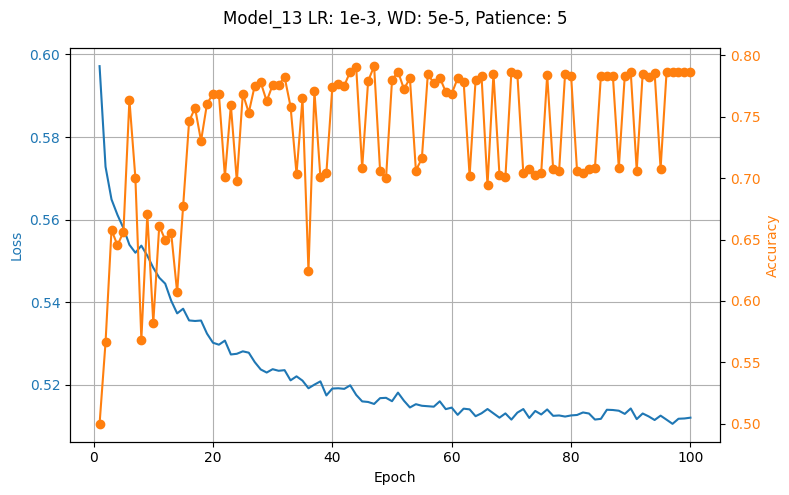


Model to test: Model_13 LR: 1e-3, WD: 1e-4, Patience: 5
feature_dim: 16384
lr=0.001 wd=0.0001 patience=5 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 15/100 loss=0.5416 val_acc=0.6217 best=0.7489:  15%|▏| 15/100 [26:20<2:25:

Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/100 loss=0.5289 val_acc=0.6760 best=0.7489:  21%|▏| 21/100 [36:45<2:16:

Epoch 00021: reducing learning rate of group 0 to 2.5000e-04.


Epoch 27/100 loss=0.5230 val_acc=0.6283 best=0.7489:  27%|▎| 27/100 [47:12<2:06:

Epoch 00027: reducing learning rate of group 0 to 1.2500e-04.


Epoch 33/100 loss=0.5180 val_acc=0.6853 best=0.7489:  33%|▎| 33/100 [57:54<1:58:

Epoch 00033: reducing learning rate of group 0 to 6.2500e-05.


Epoch 39/100 loss=0.5131 val_acc=0.6661 best=0.7489:  39%|▍| 39/100 [1:07:22<1:3

Epoch 00039: reducing learning rate of group 0 to 3.1250e-05.


Epoch 45/100 loss=0.5111 val_acc=0.6639 best=0.7489:  45%|▍| 45/100 [1:17:53<1:3

Epoch 00045: reducing learning rate of group 0 to 1.5625e-05.


Epoch 51/100 loss=0.5122 val_acc=0.6623 best=0.7489:  51%|▌| 51/100 [1:28:22<1:2

Epoch 00051: reducing learning rate of group 0 to 7.8125e-06.


Epoch 57/100 loss=0.5105 val_acc=0.6656 best=0.7489:  57%|▌| 57/100 [1:39:06<1:1

Epoch 00057: reducing learning rate of group 0 to 3.9063e-06.


Epoch 63/100 loss=0.5107 val_acc=0.7039 best=0.7489:  63%|▋| 63/100 [1:49:56<1:0

Epoch 00063: reducing learning rate of group 0 to 1.9531e-06.


Epoch 69/100 loss=0.5091 val_acc=0.7007 best=0.7489:  69%|▋| 69/100 [2:00:32<54:

Epoch 00069: reducing learning rate of group 0 to 9.7656e-07.


Epoch 75/100 loss=0.5105 val_acc=0.6957 best=0.7489:  75%|▊| 75/100 [2:11:15<44:

Epoch 00075: reducing learning rate of group 0 to 4.8828e-07.


Epoch 81/100 loss=0.5110 val_acc=0.6985 best=0.7489:  81%|▊| 81/100 [2:22:04<33:

Epoch 00081: reducing learning rate of group 0 to 2.4414e-07.


Epoch 87/100 loss=0.5096 val_acc=0.6990 best=0.7489:  87%|▊| 87/100 [2:32:43<23:

Epoch 00087: reducing learning rate of group 0 to 1.2207e-07.


Epoch 93/100 loss=0.5089 val_acc=0.7007 best=0.7489:  93%|▉| 93/100 [2:43:31<12:

Epoch 00093: reducing learning rate of group 0 to 6.1035e-08.


Epoch 99/100 loss=0.5103 val_acc=0.6985 best=0.7489:  99%|▉| 99/100 [2:54:12<01:

Epoch 00099: reducing learning rate of group 0 to 3.0518e-08.


Epoch 100/100 loss=0.5099 val_acc=0.6979 best=0.7489: 100%|█| 100/100 [2:55:59<0

Best val accuracy: 0.7489035087719298


Final TEST accuracy: 0.7447744774477447


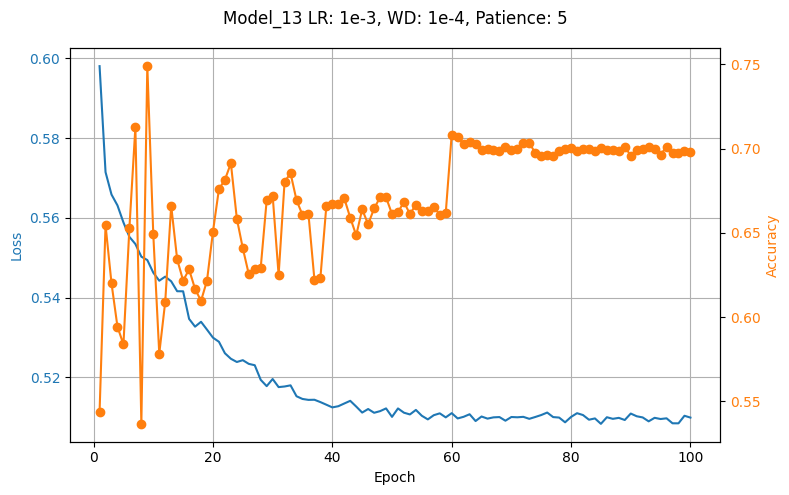


Model to test: Model_13 LR: 1e-3, WD: 5e-4, Patience: 5
feature_dim: 16384
lr=0.001 wd=0.0005 patience=5 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 15/100 loss=0.5455 val_acc=0.6003 best=0.7549:  15%|▏| 15/100 [26:24<2:29:

Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/100 loss=0.5344 val_acc=0.6787 best=0.7549:  21%|▏| 21/100 [36:53<2:23:

Epoch 00021: reducing learning rate of group 0 to 2.5000e-04.


Epoch 34/100 loss=0.5247 val_acc=0.6129 best=0.7900:  34%|▎| 34/100 [1:00:36<1:5

Epoch 00034: reducing learning rate of group 0 to 1.2500e-04.


Epoch 40/100 loss=0.5198 val_acc=0.7023 best=0.7900:  40%|▍| 40/100 [1:11:26<1:4

Epoch 00040: reducing learning rate of group 0 to 6.2500e-05.


Epoch 46/100 loss=0.5158 val_acc=0.7802 best=0.7900:  46%|▍| 46/100 [1:22:37<1:4

Epoch 00046: reducing learning rate of group 0 to 3.1250e-05.


Epoch 53/100 loss=0.5139 val_acc=0.6985 best=0.7944:  53%|▌| 53/100 [1:35:32<1:2

Epoch 00053: reducing learning rate of group 0 to 1.5625e-05.


Epoch 59/100 loss=0.5134 val_acc=0.7072 best=0.7944:  59%|▌| 59/100 [1:46:25<1:1

Epoch 00059: reducing learning rate of group 0 to 7.8125e-06.


Epoch 65/100 loss=0.5134 val_acc=0.6288 best=0.7944:  65%|▋| 65/100 [1:57:24<1:0

Epoch 00065: reducing learning rate of group 0 to 3.9063e-06.


Epoch 71/100 loss=0.5137 val_acc=0.6245 best=0.7944:  71%|▋| 71/100 [2:08:33<53:

Epoch 00071: reducing learning rate of group 0 to 1.9531e-06.


Epoch 77/100 loss=0.5140 val_acc=0.7122 best=0.7944:  77%|▊| 77/100 [2:19:38<42:

Epoch 00077: reducing learning rate of group 0 to 9.7656e-07.


Epoch 83/100 loss=0.5124 val_acc=0.7138 best=0.7944:  83%|▊| 83/100 [2:30:42<31:

Epoch 00083: reducing learning rate of group 0 to 4.8828e-07.


Epoch 89/100 loss=0.5135 val_acc=0.6321 best=0.7944:  89%|▉| 89/100 [2:41:37<20:

Epoch 00089: reducing learning rate of group 0 to 2.4414e-07.


Epoch 95/100 loss=0.5128 val_acc=0.7083 best=0.7944:  95%|▉| 95/100 [2:52:35<09:

Epoch 00095: reducing learning rate of group 0 to 1.2207e-07.


Epoch 100/100 loss=0.5136 val_acc=0.7133 best=0.7944: 100%|█| 100/100 [3:01:51<0

Best val accuracy: 0.7944078947368421


Final TEST accuracy: 0.8030803080308031


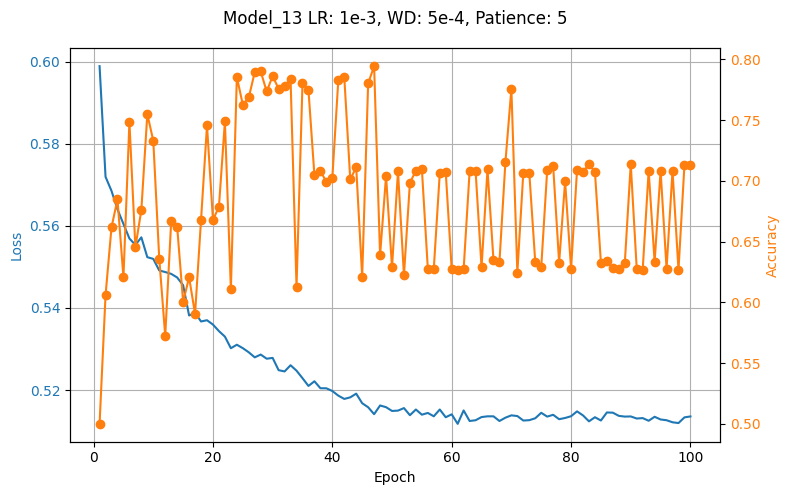


Model to test: Model_13 LR: 1e-3, WD: 0, Patience: 10
feature_dim: 16384
lr=0.001 wd=0 patience=10 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 39/100 loss=0.5347 val_acc=0.7281 best=0.8037:  39%|▍| 39/100 [1:11:11<1:5

Epoch 00039: reducing learning rate of group 0 to 5.0000e-04.


Epoch 50/100 loss=0.5245 val_acc=0.7588 best=0.8037:  50%|▌| 50/100 [1:31:19<1:3

Epoch 00050: reducing learning rate of group 0 to 2.5000e-04.


Epoch 61/100 loss=0.5162 val_acc=0.6277 best=0.8037:  61%|▌| 61/100 [1:50:49<1:0

Epoch 00061: reducing learning rate of group 0 to 1.2500e-04.


Epoch 72/100 loss=0.5134 val_acc=0.7780 best=0.8037:  72%|▋| 72/100 [2:10:47<51:

Epoch 00072: reducing learning rate of group 0 to 6.2500e-05.


Epoch 88/100 loss=0.5093 val_acc=0.6327 best=0.8087:  88%|▉| 88/100 [2:39:23<21:

Epoch 00088: reducing learning rate of group 0 to 3.1250e-05.


Epoch 99/100 loss=0.5056 val_acc=0.7390 best=0.8087:  99%|▉| 99/100 [3:00:10<01:

Epoch 00099: reducing learning rate of group 0 to 1.5625e-05.


Epoch 100/100 loss=0.5055 val_acc=0.7900 best=0.8087: 100%|█| 100/100 [3:02:01<0

Best val accuracy: 0.8086622807017544


Final TEST accuracy: 0.8041804180418042


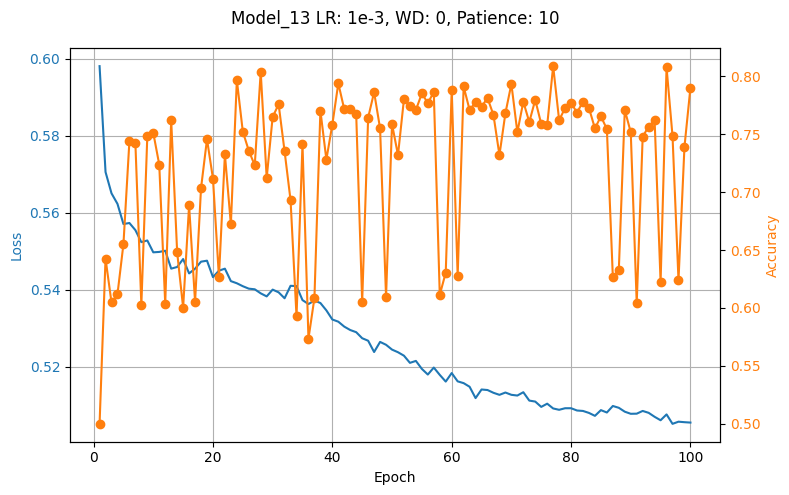


Model to test: Model_13 LR: 1e-3, WD: 1e-5, Patience: 10
feature_dim: 16384
lr=0.001 wd=1e-05 patience=10 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 39/100 loss=0.5347 val_acc=0.7281 best=0.8037:  39%|▍| 39/100 [1:12:57<1:5

Epoch 00039: reducing learning rate of group 0 to 5.0000e-04.


Epoch 50/100 loss=0.5245 val_acc=0.7588 best=0.8037:  50%|▌| 50/100 [1:33:38<1:3

Epoch 00050: reducing learning rate of group 0 to 2.5000e-04.


Epoch 61/100 loss=0.5162 val_acc=0.6277 best=0.8037:  61%|▌| 61/100 [1:54:15<1:1

Epoch 00061: reducing learning rate of group 0 to 1.2500e-04.


Epoch 72/100 loss=0.5134 val_acc=0.7780 best=0.8037:  72%|▋| 72/100 [2:14:41<51:

Epoch 00072: reducing learning rate of group 0 to 6.2500e-05.


Epoch 88/100 loss=0.5093 val_acc=0.6327 best=0.8087:  88%|▉| 88/100 [2:44:34<22:

Epoch 00088: reducing learning rate of group 0 to 3.1250e-05.


Epoch 99/100 loss=0.5056 val_acc=0.7390 best=0.8087:  99%|▉| 99/100 [3:05:01<01:

Epoch 00099: reducing learning rate of group 0 to 1.5625e-05.


Epoch 100/100 loss=0.5055 val_acc=0.7900 best=0.8087: 100%|█| 100/100 [3:06:56<0

Best val accuracy: 0.8086622807017544


Final TEST accuracy: 0.8041804180418042


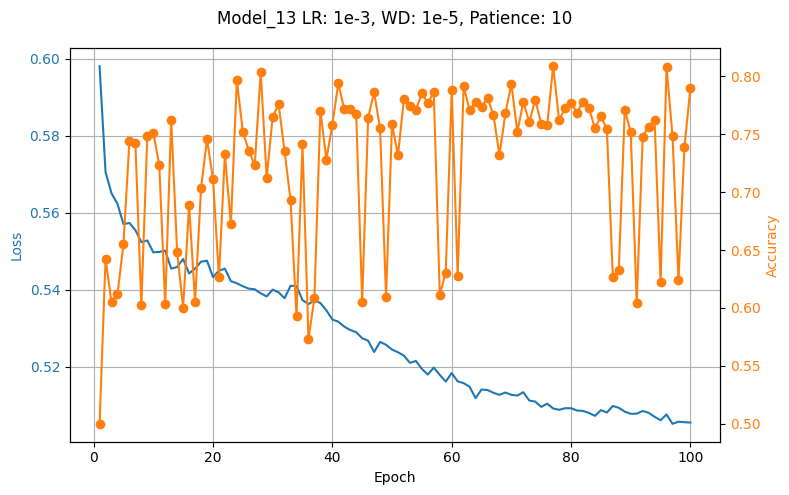


Model to test: Model_13 LR: 1e-3, WD: 5e-5, Patience: 10
feature_dim: 16384
lr=0.001 wd=5e-05 patience=10 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 17/100 loss=0.5418 val_acc=0.6036 best=0.7637:  17%|▏| 17/100 [31:14<2:36:

Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 30/100 loss=0.5275 val_acc=0.7549 best=0.7725:  30%|▎| 30/100 [56:04<2:13:

Epoch 00030: reducing learning rate of group 0 to 2.5000e-04.


Epoch 41/100 loss=0.5172 val_acc=0.7462 best=0.7725:  41%|▍| 41/100 [1:17:15<1:5

Epoch 00041: reducing learning rate of group 0 to 1.2500e-04.


Epoch 52/100 loss=0.5130 val_acc=0.6941 best=0.7725:  52%|▌| 52/100 [1:38:26<1:3

Epoch 00052: reducing learning rate of group 0 to 6.2500e-05.


Epoch 63/100 loss=0.5065 val_acc=0.6793 best=0.7725:  63%|▋| 63/100 [1:59:32<1:1

Epoch 00063: reducing learning rate of group 0 to 3.1250e-05.


Epoch 74/100 loss=0.5071 val_acc=0.6875 best=0.7725:  74%|▋| 74/100 [2:20:45<50:

Epoch 00074: reducing learning rate of group 0 to 1.5625e-05.


Epoch 85/100 loss=0.5041 val_acc=0.7029 best=0.7725:  85%|▊| 85/100 [2:42:00<29:

Epoch 00085: reducing learning rate of group 0 to 7.8125e-06.


Epoch 96/100 loss=0.5044 val_acc=0.7648 best=0.7725:  96%|▉| 96/100 [3:03:13<07:

Epoch 00096: reducing learning rate of group 0 to 3.9063e-06.


Epoch 100/100 loss=0.5043 val_acc=0.7034 best=0.7774: 100%|█| 100/100 [3:10:54<0

Best val accuracy: 0.7774122807017544


Final TEST accuracy: 0.7887788778877888


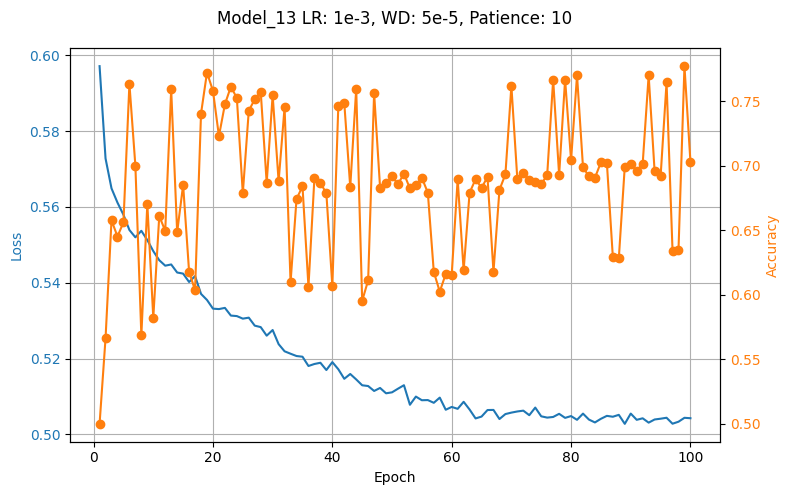


Model to test: Model_13 LR: 1e-3, WD: 1e-4, Patience: 10
feature_dim: 16384
lr=0.001 wd=0.0001 patience=10 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 20/100 loss=0.5355 val_acc=0.6201 best=0.7489:  20%|▏| 20/100 [40:56<2:43:

Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Epoch 31/100 loss=0.5190 val_acc=0.6102 best=0.7489:  31%|▎| 31/100 [1:03:17<2:1

Epoch 00031: reducing learning rate of group 0 to 2.5000e-04.


Epoch 42/100 loss=0.5103 val_acc=0.6069 best=0.7489:  42%|▍| 42/100 [1:25:41<1:5

Epoch 00042: reducing learning rate of group 0 to 1.2500e-04.


Epoch 53/100 loss=0.5020 val_acc=0.6091 best=0.7489:  53%|▌| 53/100 [1:48:05<1:3

Epoch 00053: reducing learning rate of group 0 to 6.2500e-05.


Epoch 64/100 loss=0.4969 val_acc=0.6096 best=0.7489:  64%|▋| 64/100 [2:10:26<1:1

Epoch 00064: reducing learning rate of group 0 to 3.1250e-05.


Epoch 75/100 loss=0.4958 val_acc=0.6036 best=0.7489:  75%|▊| 75/100 [2:32:51<51:

Epoch 00075: reducing learning rate of group 0 to 1.5625e-05.


Epoch 86/100 loss=0.4935 val_acc=0.5987 best=0.7489:  86%|▊| 86/100 [2:55:18<28:

Epoch 00086: reducing learning rate of group 0 to 7.8125e-06.


Epoch 97/100 loss=0.4926 val_acc=0.5987 best=0.7489:  97%|▉| 97/100 [3:17:46<06:

Epoch 00097: reducing learning rate of group 0 to 3.9063e-06.


Epoch 100/100 loss=0.4935 val_acc=0.5976 best=0.7489: 100%|█| 100/100 [3:23:55<0

Best val accuracy: 0.7489035087719298


Final TEST accuracy: 0.7447744774477447


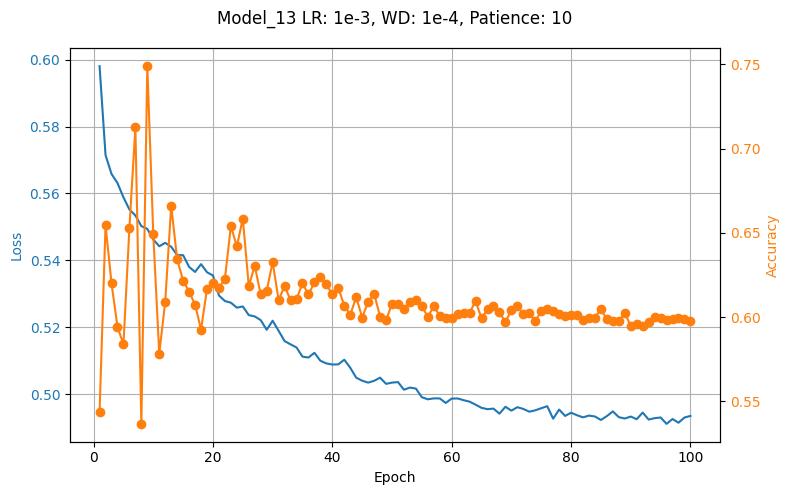


Model to test: Model_13 LR: 1e-3, WD: 5e-4, Patience: 10
feature_dim: 16384
lr=0.001 wd=0.0005 patience=10 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 39/100 loss=0.5292 val_acc=0.7363 best=0.7834:  39%|▍| 39/100 [1:20:36<2:0

Epoch 00039: reducing learning rate of group 0 to 5.0000e-04.


Epoch 50/100 loss=0.5154 val_acc=0.7286 best=0.7834:  50%|▌| 50/100 [1:43:19<1:4

Epoch 00050: reducing learning rate of group 0 to 2.5000e-04.


Epoch 61/100 loss=0.5046 val_acc=0.6283 best=0.7834:  61%|▌| 61/100 [2:05:59<1:2

Epoch 00061: reducing learning rate of group 0 to 1.2500e-04.


Epoch 72/100 loss=0.5021 val_acc=0.6223 best=0.7834:  72%|▋| 72/100 [2:28:37<57:

Epoch 00072: reducing learning rate of group 0 to 6.2500e-05.


Epoch 83/100 loss=0.5001 val_acc=0.6179 best=0.7834:  83%|▊| 83/100 [2:51:22<34:

Epoch 00083: reducing learning rate of group 0 to 3.1250e-05.


Epoch 94/100 loss=0.4981 val_acc=0.6190 best=0.7834:  94%|▉| 94/100 [3:14:10<12:

Epoch 00094: reducing learning rate of group 0 to 1.5625e-05.


Epoch 100/100 loss=0.4975 val_acc=0.7220 best=0.7834: 100%|█| 100/100 [3:26:40<0

Best val accuracy: 0.7834429824561403


Final TEST accuracy: 0.7843784378437844


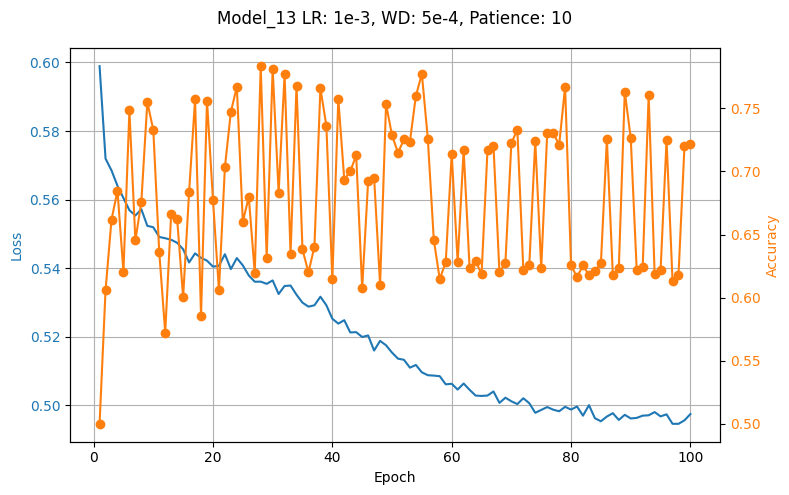


Model to test: Model_13 LR: 1e-3, WD: 0, Patience: 15
feature_dim: 16384
lr=0.001 wd=0 patience=15 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 44/100 loss=0.5367 val_acc=0.7719 best=0.8037:  44%|▍| 44/100 [1:25:43<1:4

Epoch 00044: reducing learning rate of group 0 to 5.0000e-04.


Epoch 60/100 loss=0.5230 val_acc=0.7818 best=0.8037:  60%|▌| 60/100 [1:56:44<1:1

Epoch 00060: reducing learning rate of group 0 to 2.5000e-04.


Epoch 78/100 loss=0.5122 val_acc=0.6228 best=0.8070:  78%|▊| 78/100 [2:31:33<42:

Epoch 00078: reducing learning rate of group 0 to 1.2500e-04.


Epoch 94/100 loss=0.5090 val_acc=0.8015 best=0.8070:  94%|▉| 94/100 [3:02:48<11:

Epoch 00094: reducing learning rate of group 0 to 6.2500e-05.


Epoch 100/100 loss=0.5067 val_acc=0.8010 best=0.8070: 100%|█| 100/100 [3:14:25<0

Best val accuracy: 0.8070175438596491


Final TEST accuracy: 0.8195819581958196


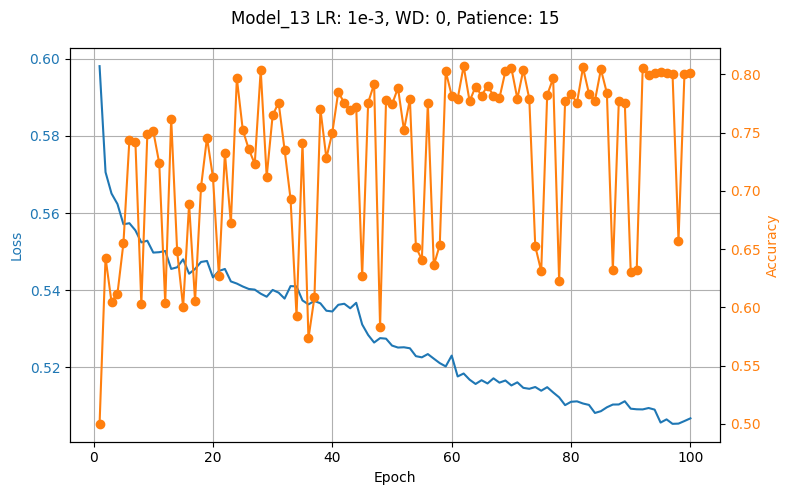


Model to test: Model_13 LR: 1e-3, WD: 1e-5, Patience: 15
feature_dim: 16384
lr=0.001 wd=1e-05 patience=15 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 44/100 loss=0.5367 val_acc=0.7719 best=0.8037:  44%|▍| 44/100 [1:30:59<1:5

Epoch 00044: reducing learning rate of group 0 to 5.0000e-04.


Epoch 60/100 loss=0.5230 val_acc=0.7818 best=0.8037:  60%|▌| 60/100 [2:03:56<1:2

Epoch 00060: reducing learning rate of group 0 to 2.5000e-04.


Epoch 78/100 loss=0.5122 val_acc=0.6228 best=0.8070:  78%|▊| 78/100 [2:40:56<45:

Epoch 00078: reducing learning rate of group 0 to 1.2500e-04.


Epoch 94/100 loss=0.5090 val_acc=0.8015 best=0.8070:  94%|▉| 94/100 [3:13:43<12:

Epoch 00094: reducing learning rate of group 0 to 6.2500e-05.


Epoch 100/100 loss=0.5067 val_acc=0.8010 best=0.8070: 100%|█| 100/100 [3:26:02<0

Best val accuracy: 0.8070175438596491


Final TEST accuracy: 0.8195819581958196


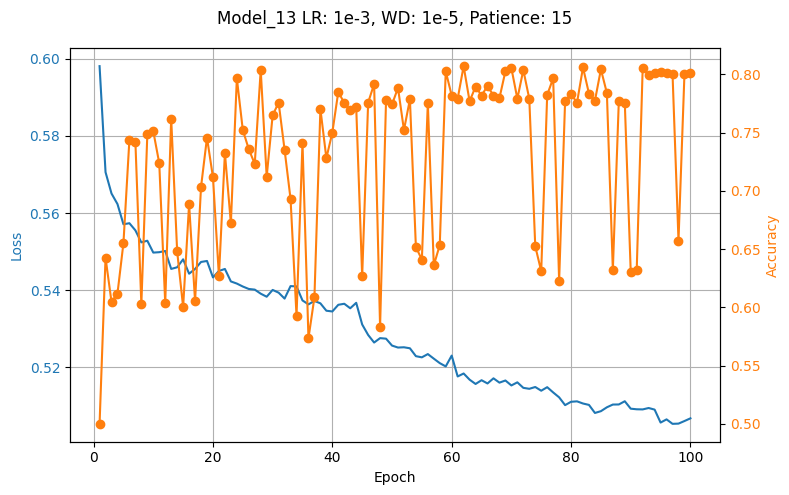


Model to test: Model_13 LR: 1e-3, WD: 5e-5, Patience: 15
feature_dim: 16384
lr=0.001 wd=5e-05 patience=15 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 22/100 loss=0.5389 val_acc=0.6880 best=0.7637:  22%|▏| 22/100 [44:44<2:38:

Epoch 00022: reducing learning rate of group 0 to 5.0000e-04.


Epoch 60/100 loss=0.5096 val_acc=0.6864 best=0.7829:  60%|▌| 60/100 [2:01:12<1:2

Epoch 00060: reducing learning rate of group 0 to 2.5000e-04.


Epoch 95/100 loss=0.4944 val_acc=0.8120 best=0.8185:  95%|▉| 95/100 [3:12:15<10:

Epoch 00095: reducing learning rate of group 0 to 1.2500e-04.


Epoch 100/100 loss=0.4884 val_acc=0.8103 best=0.8185: 100%|█| 100/100 [3:22:30<0

Best val accuracy: 0.8185307017543859


Final TEST accuracy: 0.8096809680968097


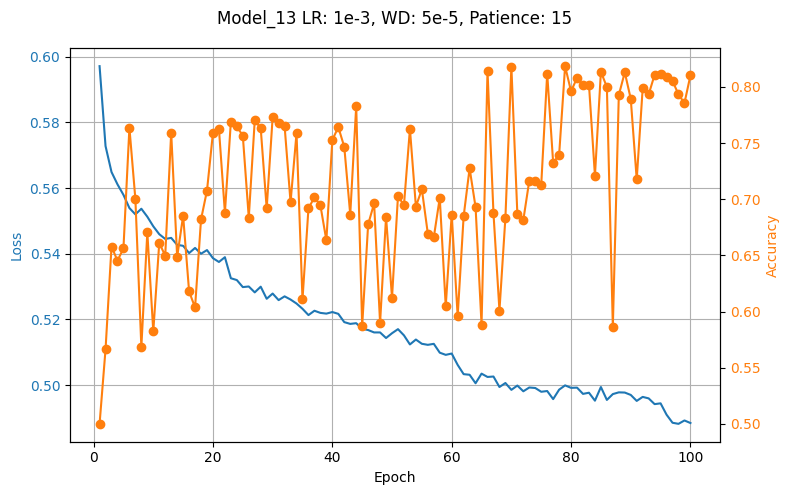


Model to test: Model_13 LR: 1e-3, WD: 1e-4, Patience: 15
feature_dim: 16384
lr=0.001 wd=0.0001 patience=15 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 25/100 loss=0.5320 val_acc=0.6075 best=0.7489:  25%|▎| 25/100 [51:02<2:31:

Epoch 00025: reducing learning rate of group 0 to 5.0000e-04.


Epoch 41/100 loss=0.5100 val_acc=0.5954 best=0.7489:  41%|▍| 41/100 [1:23:34<2:0

Epoch 00041: reducing learning rate of group 0 to 2.5000e-04.


Epoch 78/100 loss=0.4884 val_acc=0.8783 best=0.8810:  78%|▊| 78/100 [2:38:52<45:

Epoch 00078: reducing learning rate of group 0 to 1.2500e-04.


Epoch 100/100 loss=0.4851 val_acc=0.8860 best=0.8904: 100%|█| 100/100 [3:23:48<0

Best val accuracy: 0.8903508771929824


Final TEST accuracy: 0.8723872387238724


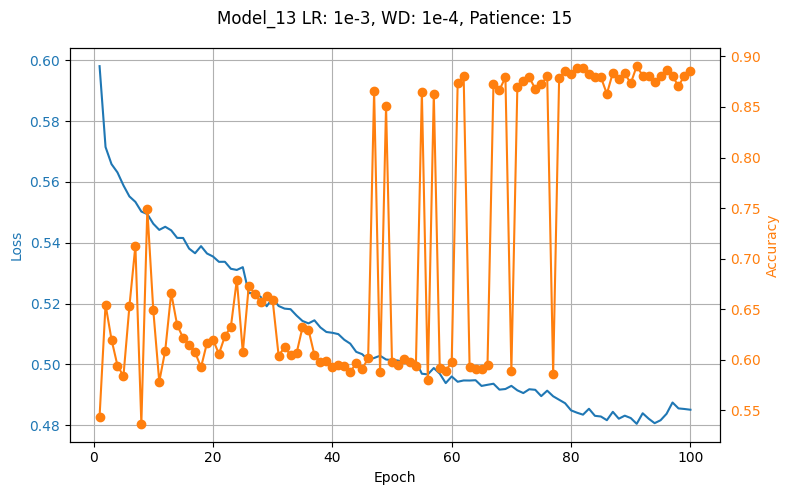


Model to test: Model_13 LR: 1e-3, WD: 5e-4, Patience: 15
feature_dim: 16384
lr=0.001 wd=0.0005 patience=15 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 71/100 loss=0.5176 val_acc=0.6086 best=0.8109:  71%|▋| 71/100 [2:16:49<56:

Epoch 00071: reducing learning rate of group 0 to 5.0000e-04.


Epoch 89/100 loss=0.5005 val_acc=0.6919 best=0.8273:  89%|▉| 89/100 [2:51:35<21:

Epoch 00089: reducing learning rate of group 0 to 2.5000e-04.


Epoch 100/100 loss=0.4902 val_acc=0.8262 best=0.8300: 100%|█| 100/100 [3:12:44<0

Best val accuracy: 0.8300438596491229


Final TEST accuracy: 0.8184818481848185


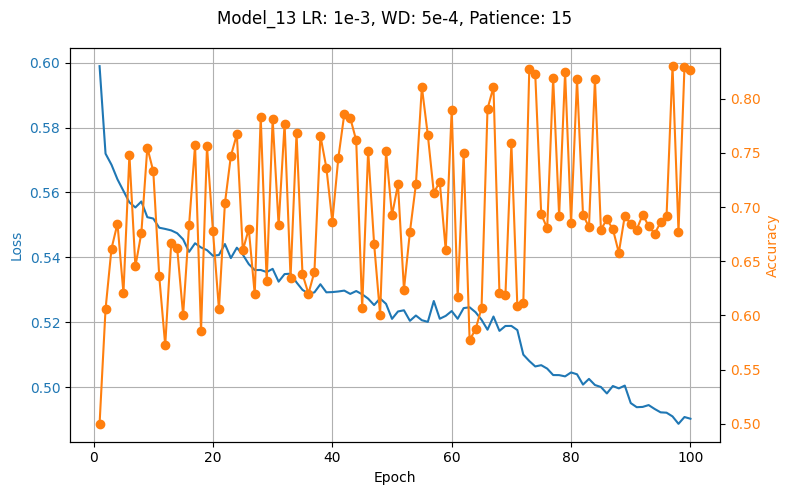

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.



Model to test: Model_6 LR: 1e-3, WD: 0, Patience: 2
feature_dim: 2048
lr=0.001 wd=0 patience=2 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 8/100 loss=0.5680 val_acc=0.5729 best=0.7171:   8%| | 8/100 [13:57<2:37:51

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 11/100 loss=0.5616 val_acc=0.5779 best=0.7171:  11%| | 11/100 [19:08<2:33:

Epoch 00011: reducing learning rate of group 0 to 2.5000e-04.


Epoch 14/100 loss=0.5582 val_acc=0.6502 best=0.7171:  14%|▏| 14/100 [24:18<2:28:

Epoch 00014: reducing learning rate of group 0 to 1.2500e-04.


Epoch 17/100 loss=0.5561 val_acc=0.6206 best=0.7171:  17%|▏| 17/100 [29:30<2:23:

Epoch 00017: reducing learning rate of group 0 to 6.2500e-05.


Epoch 20/100 loss=0.5529 val_acc=0.5976 best=0.7171:  20%|▏| 20/100 [34:39<2:17:

Epoch 00020: reducing learning rate of group 0 to 3.1250e-05.


Epoch 23/100 loss=0.5525 val_acc=0.6168 best=0.7171:  23%|▏| 23/100 [40:00<2:14:

Epoch 00023: reducing learning rate of group 0 to 1.5625e-05.


Epoch 26/100 loss=0.5532 val_acc=0.6086 best=0.7171:  26%|▎| 26/100 [45:12<2:08:

Epoch 00026: reducing learning rate of group 0 to 7.8125e-06.


Epoch 29/100 loss=0.5533 val_acc=0.6064 best=0.7171:  29%|▎| 29/100 [50:22<2:02:

Epoch 00029: reducing learning rate of group 0 to 3.9063e-06.


Epoch 32/100 loss=0.5531 val_acc=0.6129 best=0.7171:  32%|▎| 32/100 [55:32<1:57:

Epoch 00032: reducing learning rate of group 0 to 1.9531e-06.


Epoch 35/100 loss=0.5516 val_acc=0.6118 best=0.7171:  35%|▎| 35/100 [1:00:44<1:5

Epoch 00035: reducing learning rate of group 0 to 9.7656e-07.


Epoch 38/100 loss=0.5532 val_acc=0.6107 best=0.7171:  38%|▍| 38/100 [1:05:53<1:4

Epoch 00038: reducing learning rate of group 0 to 4.8828e-07.


Epoch 41/100 loss=0.5538 val_acc=0.6135 best=0.7171:  41%|▍| 41/100 [1:10:57<1:4

Epoch 00041: reducing learning rate of group 0 to 2.4414e-07.


Epoch 44/100 loss=0.5525 val_acc=0.6135 best=0.7171:  44%|▍| 44/100 [1:16:05<1:3

Epoch 00044: reducing learning rate of group 0 to 1.2207e-07.


Epoch 47/100 loss=0.5520 val_acc=0.6135 best=0.7171:  47%|▍| 47/100 [1:21:16<1:3

Epoch 00047: reducing learning rate of group 0 to 6.1035e-08.


Epoch 50/100 loss=0.5517 val_acc=0.6146 best=0.7171:  50%|▌| 50/100 [1:26:22<1:2

Epoch 00050: reducing learning rate of group 0 to 3.0518e-08.


Epoch 53/100 loss=0.5515 val_acc=0.6091 best=0.7171:  53%|▌| 53/100 [1:31:24<1:1

Epoch 00053: reducing learning rate of group 0 to 1.5259e-08.


Epoch 100/100 loss=0.5527 val_acc=0.6146 best=0.7171: 100%|█| 100/100 [2:51:02<0

Best val accuracy: 0.7171052631578947


Final TEST accuracy: 0.7348734873487349


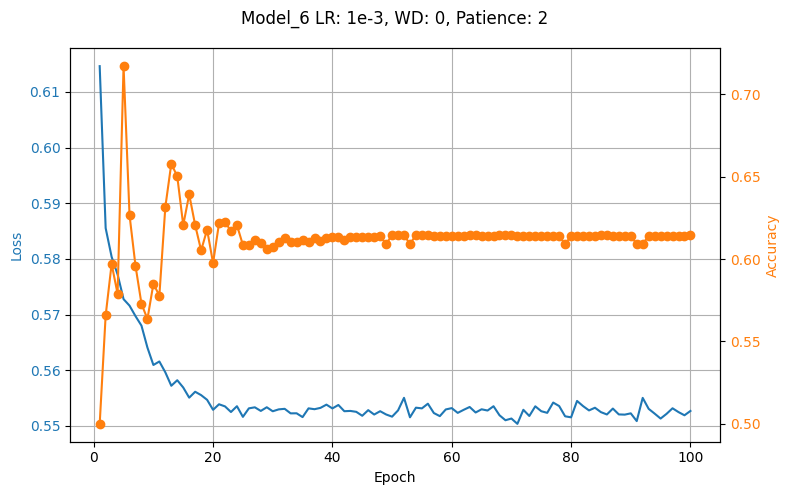


Model to test: Model_6 LR: 1e-3, WD: 1e-5, Patience: 2
feature_dim: 2048
lr=0.001 wd=1e-05 patience=2 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 8/100 loss=0.5680 val_acc=0.5729 best=0.7171:   8%| | 8/100 [13:48<2:37:08

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 11/100 loss=0.5616 val_acc=0.5779 best=0.7171:  11%| | 11/100 [18:59<2:32:

Epoch 00011: reducing learning rate of group 0 to 2.5000e-04.


Epoch 14/100 loss=0.5582 val_acc=0.6502 best=0.7171:  14%|▏| 14/100 [24:10<2:28:

Epoch 00014: reducing learning rate of group 0 to 1.2500e-04.


Epoch 17/100 loss=0.5561 val_acc=0.6206 best=0.7171:  17%|▏| 17/100 [29:15<2:21:

Epoch 00017: reducing learning rate of group 0 to 6.2500e-05.


Epoch 20/100 loss=0.5529 val_acc=0.5976 best=0.7171:  20%|▏| 20/100 [34:18<2:15:

Epoch 00020: reducing learning rate of group 0 to 3.1250e-05.


Epoch 23/100 loss=0.5525 val_acc=0.6168 best=0.7171:  23%|▏| 23/100 [39:27<2:11:

Epoch 00023: reducing learning rate of group 0 to 1.5625e-05.


Epoch 26/100 loss=0.5532 val_acc=0.6086 best=0.7171:  26%|▎| 26/100 [44:39<2:07:

Epoch 00026: reducing learning rate of group 0 to 7.8125e-06.


Epoch 29/100 loss=0.5533 val_acc=0.6064 best=0.7171:  29%|▎| 29/100 [49:55<2:03:

Epoch 00029: reducing learning rate of group 0 to 3.9063e-06.


Epoch 32/100 loss=0.5531 val_acc=0.6129 best=0.7171:  32%|▎| 32/100 [55:00<1:56:

Epoch 00032: reducing learning rate of group 0 to 1.9531e-06.


Epoch 35/100 loss=0.5516 val_acc=0.6118 best=0.7171:  35%|▎| 35/100 [1:00:07<1:5

Epoch 00035: reducing learning rate of group 0 to 9.7656e-07.


Epoch 38/100 loss=0.5532 val_acc=0.6107 best=0.7171:  38%|▍| 38/100 [1:05:22<1:4

Epoch 00038: reducing learning rate of group 0 to 4.8828e-07.


Epoch 41/100 loss=0.5538 val_acc=0.6135 best=0.7171:  41%|▍| 41/100 [1:10:31<1:4

Epoch 00041: reducing learning rate of group 0 to 2.4414e-07.


Epoch 44/100 loss=0.5525 val_acc=0.6135 best=0.7171:  44%|▍| 44/100 [1:15:37<1:3

Epoch 00044: reducing learning rate of group 0 to 1.2207e-07.


Epoch 47/100 loss=0.5520 val_acc=0.6135 best=0.7171:  47%|▍| 47/100 [1:20:44<1:3

Epoch 00047: reducing learning rate of group 0 to 6.1035e-08.


Epoch 50/100 loss=0.5517 val_acc=0.6146 best=0.7171:  50%|▌| 50/100 [1:25:54<1:2

Epoch 00050: reducing learning rate of group 0 to 3.0518e-08.


Epoch 53/100 loss=0.5515 val_acc=0.6091 best=0.7171:  53%|▌| 53/100 [1:31:07<1:2

Epoch 00053: reducing learning rate of group 0 to 1.5259e-08.


Epoch 100/100 loss=0.5527 val_acc=0.6146 best=0.7171: 100%|█| 100/100 [2:51:36<0

Best val accuracy: 0.7171052631578947


Final TEST accuracy: 0.7348734873487349


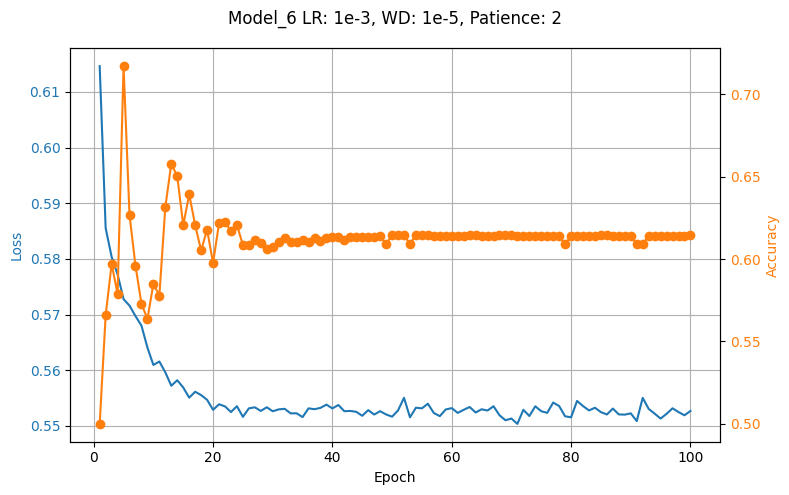


Model to test: Model_6 LR: 1e-3, WD: 5e-5, Patience: 2
feature_dim: 2048
lr=0.001 wd=5e-05 patience=2 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 8/100 loss=0.5669 val_acc=0.6228 best=0.6579:   8%| | 8/100 [13:39<2:36:37

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 11/100 loss=0.5597 val_acc=0.5927 best=0.6579:  11%| | 11/100 [18:49<2:32:

Epoch 00011: reducing learning rate of group 0 to 2.5000e-04.


Epoch 19/100 loss=0.5534 val_acc=0.6579 best=0.7325:  19%|▏| 19/100 [32:19<2:16:

Epoch 00019: reducing learning rate of group 0 to 1.2500e-04.


Epoch 22/100 loss=0.5501 val_acc=0.6732 best=0.7325:  22%|▏| 22/100 [37:30<2:13:

Epoch 00022: reducing learning rate of group 0 to 6.2500e-05.


Epoch 25/100 loss=0.5493 val_acc=0.6870 best=0.7325:  25%|▎| 25/100 [42:36<2:08:

Epoch 00025: reducing learning rate of group 0 to 3.1250e-05.


Epoch 28/100 loss=0.5475 val_acc=0.7045 best=0.7325:  28%|▎| 28/100 [47:38<2:01:

Epoch 00028: reducing learning rate of group 0 to 1.5625e-05.


Epoch 31/100 loss=0.5504 val_acc=0.7018 best=0.7325:  31%|▎| 31/100 [52:47<1:57:

Epoch 00031: reducing learning rate of group 0 to 7.8125e-06.


Epoch 34/100 loss=0.5483 val_acc=0.7018 best=0.7325:  34%|▎| 34/100 [57:54<1:52:

Epoch 00034: reducing learning rate of group 0 to 3.9063e-06.


Epoch 37/100 loss=0.5472 val_acc=0.7007 best=0.7325:  37%|▎| 37/100 [1:02:55<1:4

Epoch 00037: reducing learning rate of group 0 to 1.9531e-06.


Epoch 40/100 loss=0.5465 val_acc=0.6974 best=0.7325:  40%|▍| 40/100 [1:08:03<1:4

Epoch 00040: reducing learning rate of group 0 to 9.7656e-07.


Epoch 43/100 loss=0.5485 val_acc=0.6820 best=0.7325:  43%|▍| 43/100 [1:13:04<1:3

Epoch 00043: reducing learning rate of group 0 to 4.8828e-07.


Epoch 46/100 loss=0.5476 val_acc=0.7007 best=0.7325:  46%|▍| 46/100 [1:18:11<1:3

Epoch 00046: reducing learning rate of group 0 to 2.4414e-07.


Epoch 49/100 loss=0.5473 val_acc=0.6776 best=0.7325:  49%|▍| 49/100 [1:23:12<1:2

Epoch 00049: reducing learning rate of group 0 to 1.2207e-07.


Epoch 52/100 loss=0.5497 val_acc=0.7067 best=0.7325:  52%|▌| 52/100 [1:27:57<1:1

Epoch 00052: reducing learning rate of group 0 to 6.1035e-08.


Epoch 55/100 loss=0.5481 val_acc=0.6974 best=0.7325:  55%|▌| 55/100 [1:33:01<1:1

Epoch 00055: reducing learning rate of group 0 to 3.0518e-08.


Epoch 58/100 loss=0.5475 val_acc=0.6990 best=0.7325:  58%|▌| 58/100 [1:38:05<1:1

Epoch 00058: reducing learning rate of group 0 to 1.5259e-08.


Epoch 100/100 loss=0.5484 val_acc=0.6974 best=0.7325: 100%|█| 100/100 [2:49:32<0

Best val accuracy: 0.7324561403508771


Final TEST accuracy: 0.7414741474147415


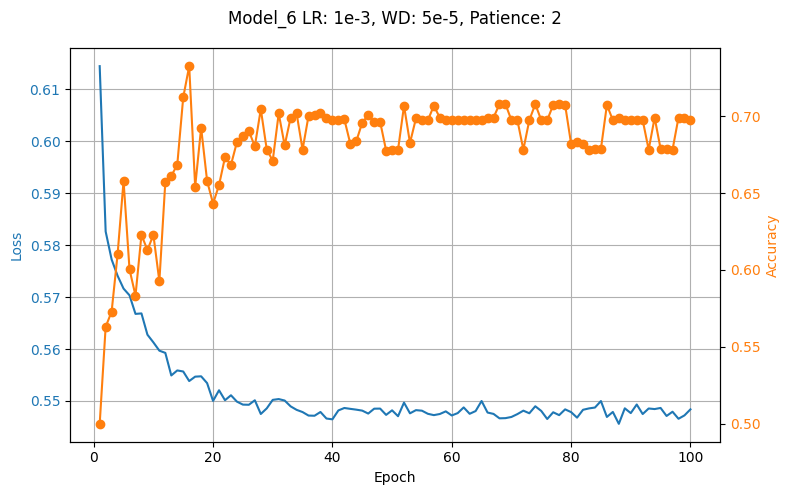


Model to test: Model_6 LR: 1e-3, WD: 1e-4, Patience: 2
feature_dim: 2048
lr=0.001 wd=0.0001 patience=2 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 8/100 loss=0.5672 val_acc=0.6732 best=0.6793:   8%| | 8/100 [13:45<2:34:52

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/100 loss=0.5560 val_acc=0.6891 best=0.7418:  16%|▏| 16/100 [27:24<2:23:

Epoch 00016: reducing learning rate of group 0 to 2.5000e-04.


Epoch 19/100 loss=0.5528 val_acc=0.6754 best=0.7418:  19%|▏| 19/100 [32:31<2:18:

Epoch 00019: reducing learning rate of group 0 to 1.2500e-04.


Epoch 22/100 loss=0.5513 val_acc=0.6859 best=0.7418:  22%|▏| 22/100 [37:35<2:12:

Epoch 00022: reducing learning rate of group 0 to 6.2500e-05.


Epoch 25/100 loss=0.5493 val_acc=0.6913 best=0.7418:  25%|▎| 25/100 [42:47<2:08:

Epoch 00025: reducing learning rate of group 0 to 3.1250e-05.


Epoch 28/100 loss=0.5484 val_acc=0.6787 best=0.7418:  28%|▎| 28/100 [47:55<2:03:

Epoch 00028: reducing learning rate of group 0 to 1.5625e-05.


Epoch 31/100 loss=0.5497 val_acc=0.6831 best=0.7418:  31%|▎| 31/100 [52:54<1:55:

Epoch 00031: reducing learning rate of group 0 to 7.8125e-06.


Epoch 34/100 loss=0.5477 val_acc=0.6886 best=0.7418:  34%|▎| 34/100 [58:00<1:51:

Epoch 00034: reducing learning rate of group 0 to 3.9063e-06.


Epoch 37/100 loss=0.5467 val_acc=0.6842 best=0.7418:  37%|▎| 37/100 [1:03:09<1:4

Epoch 00037: reducing learning rate of group 0 to 1.9531e-06.


Epoch 40/100 loss=0.5473 val_acc=0.6831 best=0.7418:  40%|▍| 40/100 [1:08:14<1:4

Epoch 00040: reducing learning rate of group 0 to 9.7656e-07.


Epoch 43/100 loss=0.5482 val_acc=0.6820 best=0.7418:  43%|▍| 43/100 [1:13:17<1:3

Epoch 00043: reducing learning rate of group 0 to 4.8828e-07.


Epoch 46/100 loss=0.5478 val_acc=0.6826 best=0.7418:  46%|▍| 46/100 [1:18:26<1:3

Epoch 00046: reducing learning rate of group 0 to 2.4414e-07.


Epoch 49/100 loss=0.5471 val_acc=0.6820 best=0.7418:  49%|▍| 49/100 [1:23:36<1:2

Epoch 00049: reducing learning rate of group 0 to 1.2207e-07.


Epoch 52/100 loss=0.5474 val_acc=0.6820 best=0.7418:  52%|▌| 52/100 [1:28:42<1:2

Epoch 00052: reducing learning rate of group 0 to 6.1035e-08.


Epoch 55/100 loss=0.5490 val_acc=0.6820 best=0.7418:  55%|▌| 55/100 [1:33:49<1:1

Epoch 00055: reducing learning rate of group 0 to 3.0518e-08.


Epoch 58/100 loss=0.5463 val_acc=0.6820 best=0.7418:  58%|▌| 58/100 [1:39:06<1:1

Epoch 00058: reducing learning rate of group 0 to 1.5259e-08.


Epoch 100/100 loss=0.5480 val_acc=0.6815 best=0.7418: 100%|█| 100/100 [2:51:42<0

Best val accuracy: 0.7417763157894737


Final TEST accuracy: 0.7535753575357536


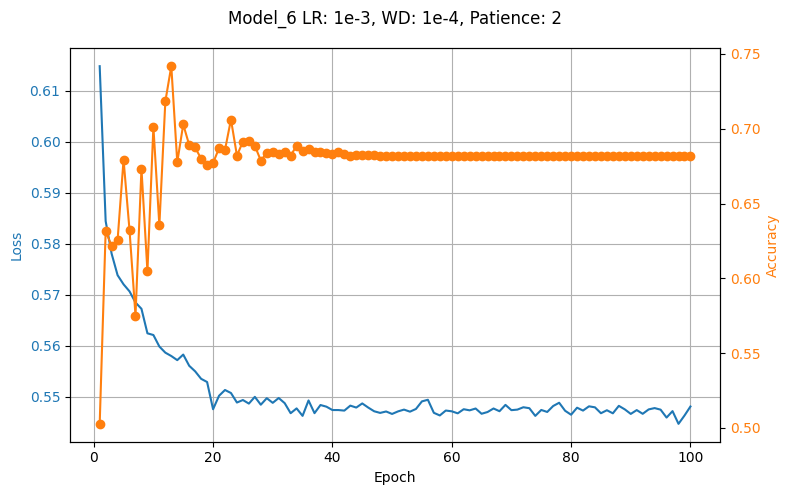


Model to test: Model_6 LR: 1e-3, WD: 5e-4, Patience: 2
feature_dim: 2048
lr=0.001 wd=0.0005 patience=2 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 8/100 loss=0.5647 val_acc=0.6535 best=0.7149:   8%| | 8/100 [13:57<2:39:01

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 11/100 loss=0.5579 val_acc=0.6530 best=0.7149:  11%| | 11/100 [19:06<2:33:

Epoch 00011: reducing learning rate of group 0 to 2.5000e-04.


Epoch 19/100 loss=0.5536 val_acc=0.7166 best=0.7516:  19%|▏| 19/100 [32:50<2:18:

Epoch 00019: reducing learning rate of group 0 to 1.2500e-04.


Epoch 22/100 loss=0.5487 val_acc=0.7412 best=0.7516:  22%|▏| 22/100 [38:00<2:13:

Epoch 00022: reducing learning rate of group 0 to 6.2500e-05.


Epoch 25/100 loss=0.5477 val_acc=0.7336 best=0.7516:  25%|▎| 25/100 [43:11<2:09:

Epoch 00025: reducing learning rate of group 0 to 3.1250e-05.


Epoch 28/100 loss=0.5494 val_acc=0.7237 best=0.7516:  28%|▎| 28/100 [48:25<2:04:

Epoch 00028: reducing learning rate of group 0 to 1.5625e-05.


Epoch 31/100 loss=0.5481 val_acc=0.7248 best=0.7516:  31%|▎| 31/100 [53:37<1:59:

Epoch 00031: reducing learning rate of group 0 to 7.8125e-06.


Epoch 34/100 loss=0.5484 val_acc=0.7303 best=0.7516:  34%|▎| 34/100 [58:45<1:53:

Epoch 00034: reducing learning rate of group 0 to 3.9063e-06.


Epoch 37/100 loss=0.5484 val_acc=0.7248 best=0.7516:  37%|▎| 37/100 [1:03:57<1:4

Epoch 00037: reducing learning rate of group 0 to 1.9531e-06.


Epoch 40/100 loss=0.5481 val_acc=0.6837 best=0.7516:  40%|▍| 40/100 [1:09:10<1:4

Epoch 00040: reducing learning rate of group 0 to 9.7656e-07.


Epoch 43/100 loss=0.5481 val_acc=0.7275 best=0.7516:  43%|▍| 43/100 [1:14:19<1:3

Epoch 00043: reducing learning rate of group 0 to 4.8828e-07.


Epoch 46/100 loss=0.5474 val_acc=0.7220 best=0.7516:  46%|▍| 46/100 [1:19:34<1:3

Epoch 00046: reducing learning rate of group 0 to 2.4414e-07.


Epoch 49/100 loss=0.5475 val_acc=0.7204 best=0.7516:  49%|▍| 49/100 [1:24:47<1:2

Epoch 00049: reducing learning rate of group 0 to 1.2207e-07.


Epoch 52/100 loss=0.5479 val_acc=0.7264 best=0.7516:  52%|▌| 52/100 [1:30:00<1:2

Epoch 00052: reducing learning rate of group 0 to 6.1035e-08.


Epoch 55/100 loss=0.5467 val_acc=0.7209 best=0.7516:  55%|▌| 55/100 [1:35:22<1:1

Epoch 00055: reducing learning rate of group 0 to 3.0518e-08.


Epoch 58/100 loss=0.5457 val_acc=0.7270 best=0.7516:  58%|▌| 58/100 [1:40:35<1:1

Epoch 00058: reducing learning rate of group 0 to 1.5259e-08.


Epoch 100/100 loss=0.5454 val_acc=0.7209 best=0.7516: 100%|█| 100/100 [2:52:54<0

Best val accuracy: 0.7516447368421053


Final TEST accuracy: 0.7403740374037404


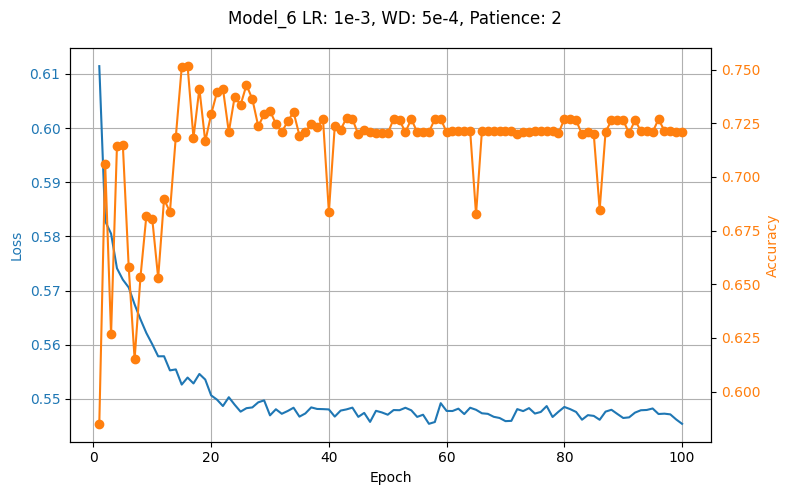


Model to test: Model_6 LR: 1e-3, WD: 0, Patience: 5
feature_dim: 2048
lr=0.001 wd=0 patience=5 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 11/100 loss=0.5632 val_acc=0.5729 best=0.7171:  11%| | 11/100 [18:56<2:31:

Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/100 loss=0.5570 val_acc=0.5948 best=0.7171:  17%|▏| 17/100 [29:15<2:22:

Epoch 00017: reducing learning rate of group 0 to 2.5000e-04.


Epoch 23/100 loss=0.5512 val_acc=0.6069 best=0.7171:  23%|▏| 23/100 [39:34<2:12:

Epoch 00023: reducing learning rate of group 0 to 1.2500e-04.


Epoch 29/100 loss=0.5497 val_acc=0.6091 best=0.7171:  29%|▎| 29/100 [49:55<2:01:

Epoch 00029: reducing learning rate of group 0 to 6.2500e-05.


Epoch 35/100 loss=0.5461 val_acc=0.5987 best=0.7171:  35%|▎| 35/100 [1:00:17<1:5

Epoch 00035: reducing learning rate of group 0 to 3.1250e-05.


Epoch 41/100 loss=0.5478 val_acc=0.6047 best=0.7171:  41%|▍| 41/100 [1:10:37<1:4

Epoch 00041: reducing learning rate of group 0 to 1.5625e-05.


Epoch 47/100 loss=0.5466 val_acc=0.6020 best=0.7171:  47%|▍| 47/100 [1:20:51<1:3

Epoch 00047: reducing learning rate of group 0 to 7.8125e-06.


Epoch 53/100 loss=0.5468 val_acc=0.6031 best=0.7171:  53%|▌| 53/100 [1:31:08<1:2

Epoch 00053: reducing learning rate of group 0 to 3.9063e-06.


Epoch 59/100 loss=0.5463 val_acc=0.6058 best=0.7171:  59%|▌| 59/100 [1:41:21<1:0

Epoch 00059: reducing learning rate of group 0 to 1.9531e-06.


Epoch 65/100 loss=0.5452 val_acc=0.6064 best=0.7171:  65%|▋| 65/100 [1:51:35<59:

Epoch 00065: reducing learning rate of group 0 to 9.7656e-07.


Epoch 71/100 loss=0.5453 val_acc=0.6069 best=0.7171:  71%|▋| 71/100 [2:01:52<49:

Epoch 00071: reducing learning rate of group 0 to 4.8828e-07.


Epoch 77/100 loss=0.5471 val_acc=0.6069 best=0.7171:  77%|▊| 77/100 [2:12:05<39:

Epoch 00077: reducing learning rate of group 0 to 2.4414e-07.


Epoch 83/100 loss=0.5457 val_acc=0.6069 best=0.7171:  83%|▊| 83/100 [2:22:28<29:

Epoch 00083: reducing learning rate of group 0 to 1.2207e-07.


Epoch 89/100 loss=0.5457 val_acc=0.6069 best=0.7171:  89%|▉| 89/100 [2:32:53<19:

Epoch 00089: reducing learning rate of group 0 to 6.1035e-08.


Epoch 95/100 loss=0.5450 val_acc=0.6069 best=0.7171:  95%|▉| 95/100 [2:42:33<08:

Epoch 00095: reducing learning rate of group 0 to 3.0518e-08.


Epoch 100/100 loss=0.5474 val_acc=0.6069 best=0.7171: 100%|█| 100/100 [2:51:27<0

Best val accuracy: 0.7171052631578947


Final TEST accuracy: 0.7348734873487349


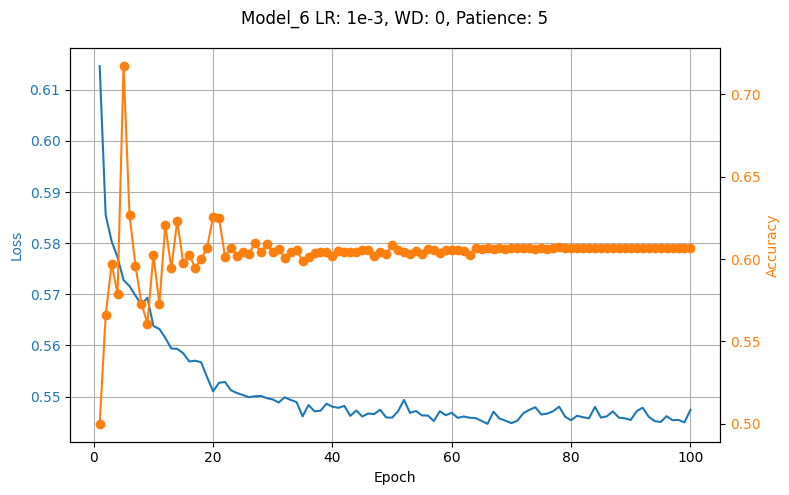


Model to test: Model_6 LR: 1e-3, WD: 1e-5, Patience: 5
feature_dim: 2048
lr=0.001 wd=1e-05 patience=5 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 11/100 loss=0.5632 val_acc=0.5729 best=0.7171:  11%| | 11/100 [19:40<2:37:

Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/100 loss=0.5570 val_acc=0.5948 best=0.7171:  17%|▏| 17/100 [30:20<2:27:

Epoch 00017: reducing learning rate of group 0 to 2.5000e-04.


Epoch 23/100 loss=0.5512 val_acc=0.6069 best=0.7171:  23%|▏| 23/100 [40:57<2:16:

Epoch 00023: reducing learning rate of group 0 to 1.2500e-04.


Epoch 29/100 loss=0.5497 val_acc=0.6091 best=0.7171:  29%|▎| 29/100 [51:35<2:05:

Epoch 00029: reducing learning rate of group 0 to 6.2500e-05.


Epoch 35/100 loss=0.5461 val_acc=0.5987 best=0.7171:  35%|▎| 35/100 [1:02:12<1:5

Epoch 00035: reducing learning rate of group 0 to 3.1250e-05.


Epoch 41/100 loss=0.5478 val_acc=0.6047 best=0.7171:  41%|▍| 41/100 [1:12:52<1:4

Epoch 00041: reducing learning rate of group 0 to 1.5625e-05.


Epoch 47/100 loss=0.5466 val_acc=0.6020 best=0.7171:  47%|▍| 47/100 [1:23:31<1:3

Epoch 00047: reducing learning rate of group 0 to 7.8125e-06.


Epoch 53/100 loss=0.5468 val_acc=0.6031 best=0.7171:  53%|▌| 53/100 [1:34:06<1:2

Epoch 00053: reducing learning rate of group 0 to 3.9063e-06.


Epoch 59/100 loss=0.5463 val_acc=0.6058 best=0.7171:  59%|▌| 59/100 [1:44:41<1:1

Epoch 00059: reducing learning rate of group 0 to 1.9531e-06.


Epoch 65/100 loss=0.5452 val_acc=0.6064 best=0.7171:  65%|▋| 65/100 [1:55:14<1:0

Epoch 00065: reducing learning rate of group 0 to 9.7656e-07.


Epoch 71/100 loss=0.5453 val_acc=0.6069 best=0.7171:  71%|▋| 71/100 [2:05:55<51:

Epoch 00071: reducing learning rate of group 0 to 4.8828e-07.


Epoch 77/100 loss=0.5471 val_acc=0.6069 best=0.7171:  77%|▊| 77/100 [2:16:33<40:

Epoch 00077: reducing learning rate of group 0 to 2.4414e-07.


Epoch 83/100 loss=0.5457 val_acc=0.6069 best=0.7171:  83%|▊| 83/100 [2:27:15<30:

Epoch 00083: reducing learning rate of group 0 to 1.2207e-07.


Epoch 89/100 loss=0.5457 val_acc=0.6069 best=0.7171:  89%|▉| 89/100 [2:37:45<19:

Epoch 00089: reducing learning rate of group 0 to 6.1035e-08.


Epoch 95/100 loss=0.5450 val_acc=0.6069 best=0.7171:  95%|▉| 95/100 [2:48:25<08:

Epoch 00095: reducing learning rate of group 0 to 3.0518e-08.


Epoch 100/100 loss=0.5474 val_acc=0.6069 best=0.7171: 100%|█| 100/100 [2:57:14<0

Best val accuracy: 0.7171052631578947


Final TEST accuracy: 0.7348734873487349


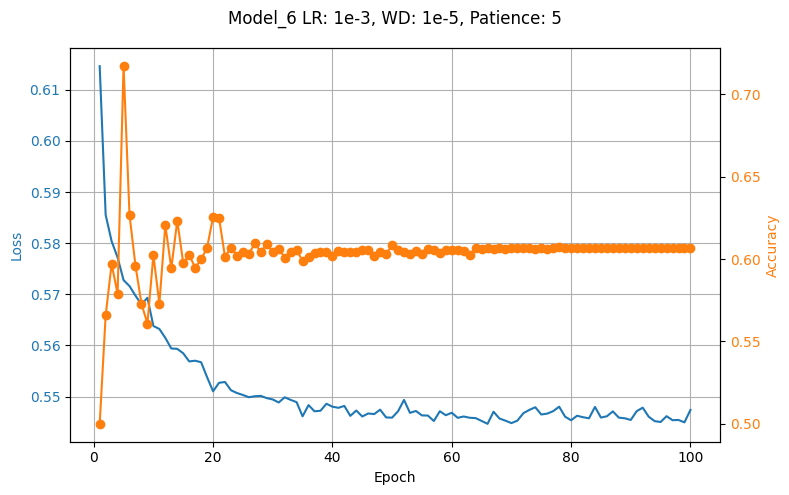


Model to test: Model_6 LR: 1e-3, WD: 5e-5, Patience: 5
feature_dim: 2048
lr=0.001 wd=5e-05 patience=5 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 11/100 loss=0.5638 val_acc=0.5839 best=0.6579:  11%| | 11/100 [19:42<2:38:

Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/100 loss=0.5552 val_acc=0.6184 best=0.6579:  17%|▏| 17/100 [30:15<2:25:

Epoch 00017: reducing learning rate of group 0 to 2.5000e-04.


Epoch 23/100 loss=0.5509 val_acc=0.6195 best=0.6579:  23%|▏| 23/100 [40:45<2:15:

Epoch 00023: reducing learning rate of group 0 to 1.2500e-04.


Epoch 29/100 loss=0.5474 val_acc=0.6321 best=0.6579:  29%|▎| 29/100 [51:16<2:04:

Epoch 00029: reducing learning rate of group 0 to 6.2500e-05.


Epoch 35/100 loss=0.5468 val_acc=0.6217 best=0.6579:  35%|▎| 35/100 [1:01:39<1:5

Epoch 00035: reducing learning rate of group 0 to 3.1250e-05.


Epoch 41/100 loss=0.5446 val_acc=0.6272 best=0.6579:  41%|▍| 41/100 [1:12:03<1:4

Epoch 00041: reducing learning rate of group 0 to 1.5625e-05.


Epoch 47/100 loss=0.5467 val_acc=0.6234 best=0.6579:  47%|▍| 47/100 [1:22:28<1:3

Epoch 00047: reducing learning rate of group 0 to 7.8125e-06.


Epoch 53/100 loss=0.5428 val_acc=0.6239 best=0.6579:  53%|▌| 53/100 [1:32:57<1:2

Epoch 00053: reducing learning rate of group 0 to 3.9063e-06.


Epoch 59/100 loss=0.5432 val_acc=0.6299 best=0.6579:  59%|▌| 59/100 [1:43:25<1:1

Epoch 00059: reducing learning rate of group 0 to 1.9531e-06.


Epoch 65/100 loss=0.5447 val_acc=0.6272 best=0.6579:  65%|▋| 65/100 [1:53:48<1:0

Epoch 00065: reducing learning rate of group 0 to 9.7656e-07.


Epoch 71/100 loss=0.5432 val_acc=0.6261 best=0.6579:  71%|▋| 71/100 [2:04:10<50:

Epoch 00071: reducing learning rate of group 0 to 4.8828e-07.


Epoch 77/100 loss=0.5454 val_acc=0.6261 best=0.6579:  77%|▊| 77/100 [2:14:36<39:

Epoch 00077: reducing learning rate of group 0 to 2.4414e-07.


Epoch 83/100 loss=0.5435 val_acc=0.6261 best=0.6579:  83%|▊| 83/100 [2:25:01<29:

Epoch 00083: reducing learning rate of group 0 to 1.2207e-07.


Epoch 89/100 loss=0.5455 val_acc=0.6261 best=0.6579:  89%|▉| 89/100 [2:35:22<18:

Epoch 00089: reducing learning rate of group 0 to 6.1035e-08.


Epoch 95/100 loss=0.5451 val_acc=0.6255 best=0.6579:  95%|▉| 95/100 [2:45:46<08:

Epoch 00095: reducing learning rate of group 0 to 3.0518e-08.


Epoch 100/100 loss=0.5451 val_acc=0.6255 best=0.6579: 100%|█| 100/100 [2:54:25<0

Best val accuracy: 0.6578947368421053


Final TEST accuracy: 0.6556655665566556


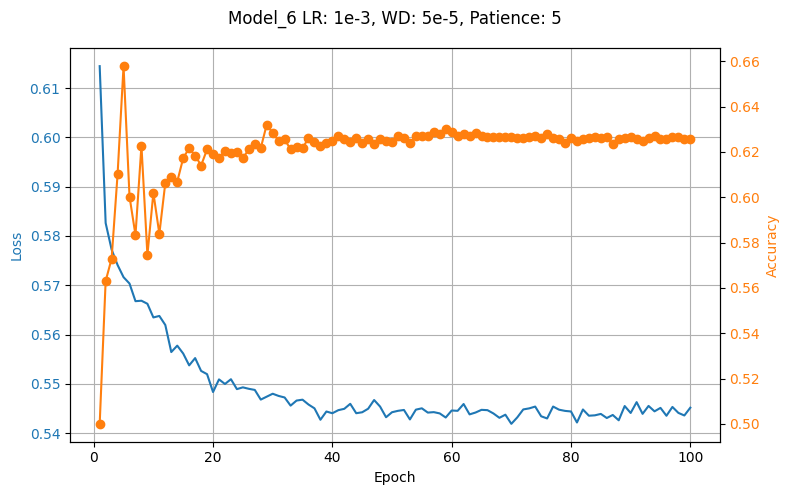


Model to test: Model_6 LR: 1e-3, WD: 1e-4, Patience: 5
feature_dim: 2048
lr=0.001 wd=0.0001 patience=5 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 19/100 loss=0.5570 val_acc=0.6848 best=0.7423:  19%|▏| 19/100 [33:09<2:19:

Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Epoch 26/100 loss=0.5480 val_acc=0.7527 best=0.7615:  26%|▎| 26/100 [45:19<2:08:

Epoch 00026: reducing learning rate of group 0 to 2.5000e-04.


Epoch 37/100 loss=0.5419 val_acc=0.7659 best=0.7697:  37%|▎| 37/100 [1:04:28<1:5

Epoch 00037: reducing learning rate of group 0 to 1.2500e-04.


Epoch 43/100 loss=0.5392 val_acc=0.7681 best=0.7697:  43%|▍| 43/100 [1:14:55<1:3

Epoch 00043: reducing learning rate of group 0 to 6.2500e-05.


Epoch 49/100 loss=0.5376 val_acc=0.7604 best=0.7697:  49%|▍| 49/100 [1:25:22<1:2

Epoch 00049: reducing learning rate of group 0 to 3.1250e-05.


Epoch 55/100 loss=0.5385 val_acc=0.7577 best=0.7697:  55%|▌| 55/100 [1:35:49<1:1

Epoch 00055: reducing learning rate of group 0 to 1.5625e-05.


Epoch 61/100 loss=0.5360 val_acc=0.7610 best=0.7697:  61%|▌| 61/100 [1:46:06<1:0

Epoch 00061: reducing learning rate of group 0 to 7.8125e-06.


Epoch 67/100 loss=0.5353 val_acc=0.7577 best=0.7697:  67%|▋| 67/100 [1:56:32<57:

Epoch 00067: reducing learning rate of group 0 to 3.9063e-06.


Epoch 73/100 loss=0.5358 val_acc=0.7610 best=0.7697:  73%|▋| 73/100 [2:06:58<46:

Epoch 00073: reducing learning rate of group 0 to 1.9531e-06.


Epoch 79/100 loss=0.5353 val_acc=0.7588 best=0.7697:  79%|▊| 79/100 [2:17:21<36:

Epoch 00079: reducing learning rate of group 0 to 9.7656e-07.


Epoch 85/100 loss=0.5358 val_acc=0.7604 best=0.7697:  85%|▊| 85/100 [2:27:51<26:

Epoch 00085: reducing learning rate of group 0 to 4.8828e-07.


Epoch 91/100 loss=0.5362 val_acc=0.7599 best=0.7697:  91%|▉| 91/100 [2:38:14<15:

Epoch 00091: reducing learning rate of group 0 to 2.4414e-07.


Epoch 97/100 loss=0.5359 val_acc=0.7593 best=0.7697:  97%|▉| 97/100 [2:48:41<05:

Epoch 00097: reducing learning rate of group 0 to 1.2207e-07.


Epoch 100/100 loss=0.5367 val_acc=0.7593 best=0.7697: 100%|█| 100/100 [2:53:54<0

Best val accuracy: 0.7697368421052632


Final TEST accuracy: 0.7777777777777778


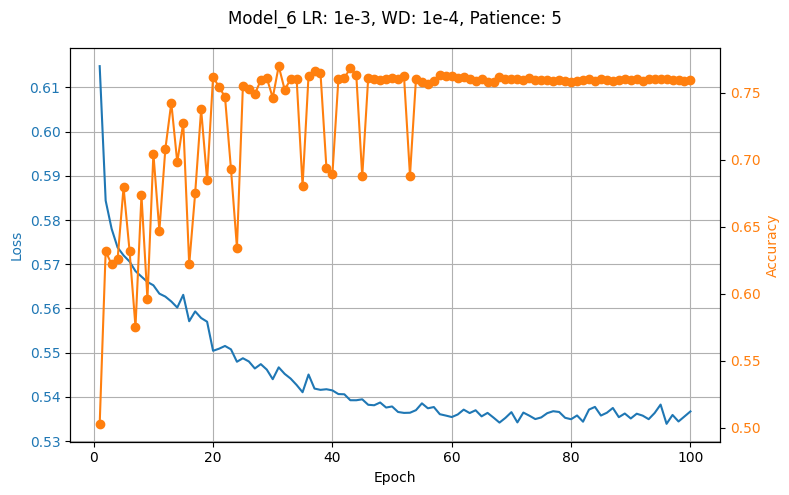


Model to test: Model_6 LR: 1e-3, WD: 5e-4, Patience: 5
feature_dim: 2048
lr=0.001 wd=0.0005 patience=5 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 11/100 loss=0.5637 val_acc=0.5521 best=0.7149:  11%| | 11/100 [19:13<2:32:

Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


Epoch 25/100 loss=0.5498 val_acc=0.7445 best=0.7533:  25%|▎| 25/100 [43:23<2:09:

Epoch 00025: reducing learning rate of group 0 to 2.5000e-04.


Epoch 35/100 loss=0.5437 val_acc=0.7423 best=0.7571:  35%|▎| 35/100 [1:00:47<1:5

Epoch 00035: reducing learning rate of group 0 to 1.2500e-04.


Epoch 50/100 loss=0.5418 val_acc=0.5757 best=0.7703:  50%|▌| 50/100 [1:26:48<1:2

Epoch 00050: reducing learning rate of group 0 to 6.2500e-05.


Epoch 56/100 loss=0.5383 val_acc=0.7007 best=0.7703:  56%|▌| 56/100 [1:37:18<1:1

Epoch 00056: reducing learning rate of group 0 to 3.1250e-05.


Epoch 62/100 loss=0.5392 val_acc=0.7319 best=0.7703:  62%|▌| 62/100 [1:47:39<1:0

Epoch 00062: reducing learning rate of group 0 to 1.5625e-05.


Epoch 68/100 loss=0.5370 val_acc=0.7374 best=0.7703:  68%|▋| 68/100 [1:58:06<55:

Epoch 00068: reducing learning rate of group 0 to 7.8125e-06.


Epoch 74/100 loss=0.5378 val_acc=0.7379 best=0.7703:  74%|▋| 74/100 [2:08:32<44:

Epoch 00074: reducing learning rate of group 0 to 3.9063e-06.


Epoch 80/100 loss=0.5384 val_acc=0.7396 best=0.7703:  80%|▊| 80/100 [2:19:00<34:

Epoch 00080: reducing learning rate of group 0 to 1.9531e-06.


Epoch 86/100 loss=0.5372 val_acc=0.7390 best=0.7703:  86%|▊| 86/100 [2:29:29<24:

Epoch 00086: reducing learning rate of group 0 to 9.7656e-07.


Epoch 92/100 loss=0.5367 val_acc=0.7346 best=0.7703:  92%|▉| 92/100 [2:39:55<13:

Epoch 00092: reducing learning rate of group 0 to 4.8828e-07.


Epoch 98/100 loss=0.5366 val_acc=0.7440 best=0.7703:  98%|▉| 98/100 [2:50:14<03:

Epoch 00098: reducing learning rate of group 0 to 2.4414e-07.


Epoch 100/100 loss=0.5367 val_acc=0.7451 best=0.7703: 100%|█| 100/100 [2:53:41<0

Best val accuracy: 0.7702850877192983


Final TEST accuracy: 0.768976897689769


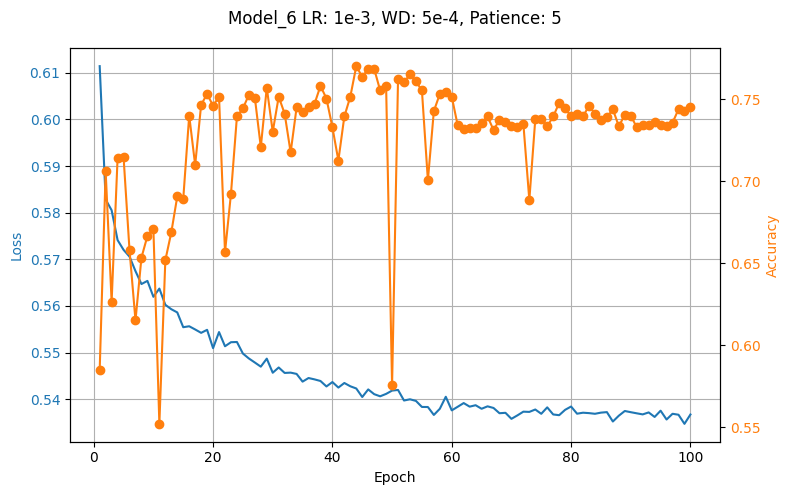


Model to test: Model_6 LR: 1e-3, WD: 0, Patience: 10
feature_dim: 2048
lr=0.001 wd=0 patience=10 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 16/100 loss=0.5613 val_acc=0.6064 best=0.7171:  16%|▏| 16/100 [27:58<2:25:

Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 27/100 loss=0.5506 val_acc=0.6151 best=0.7171:  27%|▎| 27/100 [47:05<2:07:

Epoch 00027: reducing learning rate of group 0 to 2.5000e-04.


Epoch 38/100 loss=0.5437 val_acc=0.6212 best=0.7171:  38%|▍| 38/100 [1:06:18<1:4

Epoch 00038: reducing learning rate of group 0 to 1.2500e-04.


Epoch 49/100 loss=0.5408 val_acc=0.6212 best=0.7171:  49%|▍| 49/100 [1:25:26<1:2

Epoch 00049: reducing learning rate of group 0 to 6.2500e-05.


Epoch 60/100 loss=0.5405 val_acc=0.6234 best=0.7171:  60%|▌| 60/100 [1:44:35<1:0

Epoch 00060: reducing learning rate of group 0 to 3.1250e-05.


Epoch 71/100 loss=0.5385 val_acc=0.6294 best=0.7171:  71%|▋| 71/100 [2:03:37<50:

Epoch 00071: reducing learning rate of group 0 to 1.5625e-05.


Epoch 82/100 loss=0.5378 val_acc=0.6245 best=0.7171:  82%|▊| 82/100 [2:22:36<30:

Epoch 00082: reducing learning rate of group 0 to 7.8125e-06.


Epoch 93/100 loss=0.5386 val_acc=0.6239 best=0.7171:  93%|▉| 93/100 [2:41:41<12:

Epoch 00093: reducing learning rate of group 0 to 3.9063e-06.


Epoch 100/100 loss=0.5375 val_acc=0.6234 best=0.7171: 100%|█| 100/100 [2:53:48<0

Best val accuracy: 0.7171052631578947


Final TEST accuracy: 0.7348734873487349


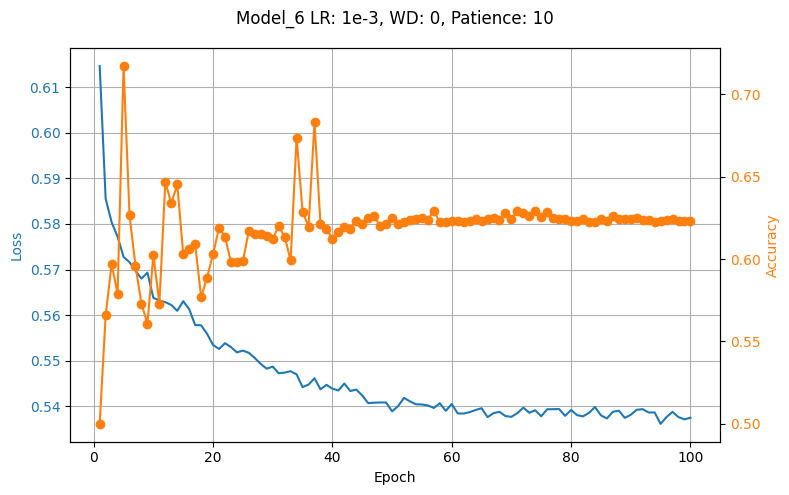


Model to test: Model_6 LR: 1e-3, WD: 1e-5, Patience: 10
feature_dim: 2048
lr=0.001 wd=1e-05 patience=10 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 16/100 loss=0.5613 val_acc=0.6064 best=0.7171:  16%|▏| 16/100 [28:02<2:26:

Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 27/100 loss=0.5506 val_acc=0.6151 best=0.7171:  27%|▎| 27/100 [47:08<2:07:

Epoch 00027: reducing learning rate of group 0 to 2.5000e-04.


Epoch 38/100 loss=0.5437 val_acc=0.6212 best=0.7171:  38%|▍| 38/100 [1:06:12<1:4

Epoch 00038: reducing learning rate of group 0 to 1.2500e-04.


Epoch 49/100 loss=0.5408 val_acc=0.6212 best=0.7171:  49%|▍| 49/100 [1:25:19<1:2

Epoch 00049: reducing learning rate of group 0 to 6.2500e-05.


Epoch 60/100 loss=0.5405 val_acc=0.6234 best=0.7171:  60%|▌| 60/100 [1:44:20<1:0

Epoch 00060: reducing learning rate of group 0 to 3.1250e-05.


Epoch 71/100 loss=0.5385 val_acc=0.6294 best=0.7171:  71%|▋| 71/100 [2:03:29<50:

Epoch 00071: reducing learning rate of group 0 to 1.5625e-05.


Epoch 82/100 loss=0.5378 val_acc=0.6245 best=0.7171:  82%|▊| 82/100 [2:22:28<31:

Epoch 00082: reducing learning rate of group 0 to 7.8125e-06.


Epoch 93/100 loss=0.5386 val_acc=0.6239 best=0.7171:  93%|▉| 93/100 [2:41:38<12:

Epoch 00093: reducing learning rate of group 0 to 3.9063e-06.


Epoch 100/100 loss=0.5375 val_acc=0.6234 best=0.7171: 100%|█| 100/100 [2:53:48<0

Best val accuracy: 0.7171052631578947


Final TEST accuracy: 0.7348734873487349


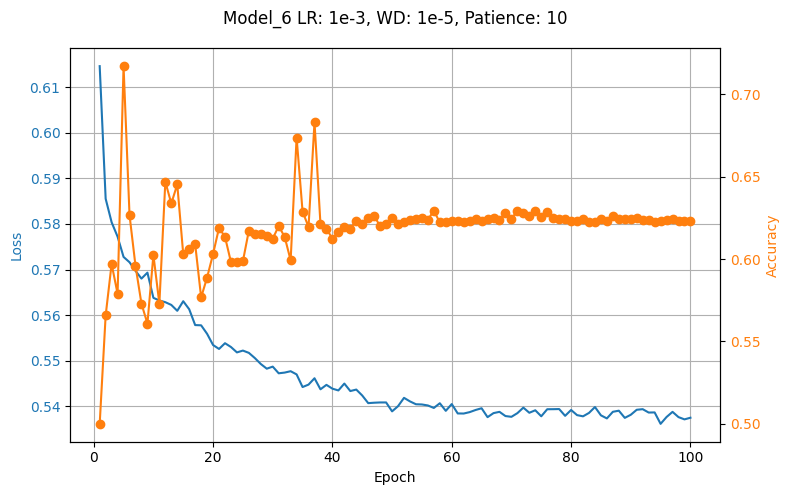


Model to test: Model_6 LR: 1e-3, WD: 5e-5, Patience: 10
feature_dim: 2048
lr=0.001 wd=5e-05 patience=10 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 25/100 loss=0.5567 val_acc=0.6321 best=0.7056:  25%|▎| 25/100 [43:33<2:10:

Epoch 00025: reducing learning rate of group 0 to 5.0000e-04.


Epoch 36/100 loss=0.5460 val_acc=0.6195 best=0.7056:  36%|▎| 36/100 [1:02:39<1:5

Epoch 00036: reducing learning rate of group 0 to 2.5000e-04.


Epoch 47/100 loss=0.5417 val_acc=0.6206 best=0.7056:  47%|▍| 47/100 [1:21:48<1:3

Epoch 00047: reducing learning rate of group 0 to 1.2500e-04.


Epoch 58/100 loss=0.5394 val_acc=0.6228 best=0.7056:  58%|▌| 58/100 [1:41:03<1:1

Epoch 00058: reducing learning rate of group 0 to 6.2500e-05.


Epoch 69/100 loss=0.5380 val_acc=0.6245 best=0.7056:  69%|▋| 69/100 [2:00:11<53:

Epoch 00069: reducing learning rate of group 0 to 3.1250e-05.


Epoch 80/100 loss=0.5355 val_acc=0.6239 best=0.7056:  80%|▊| 80/100 [2:19:16<34:

Epoch 00080: reducing learning rate of group 0 to 1.5625e-05.


Epoch 91/100 loss=0.5381 val_acc=0.6255 best=0.7056:  91%|▉| 91/100 [2:38:32<15:

Epoch 00091: reducing learning rate of group 0 to 7.8125e-06.


Epoch 100/100 loss=0.5356 val_acc=0.6283 best=0.7056: 100%|█| 100/100 [2:54:12<0

Best val accuracy: 0.7055921052631579


Final TEST accuracy: 0.7128712871287128


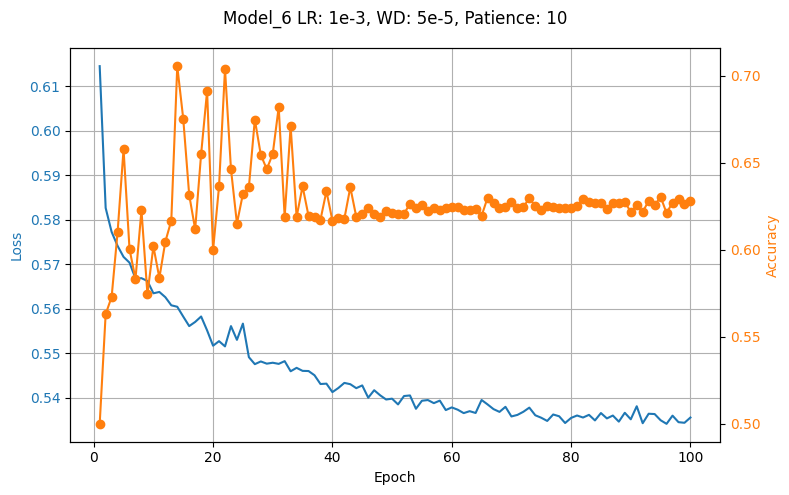


Model to test: Model_6 LR: 1e-3, WD: 1e-4, Patience: 10
feature_dim: 2048
lr=0.001 wd=0.0001 patience=10 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 24/100 loss=0.5524 val_acc=0.6255 best=0.7423:  24%|▏| 24/100 [42:03<2:12:

Epoch 00024: reducing learning rate of group 0 to 5.0000e-04.


Epoch 69/100 loss=0.5304 val_acc=0.7248 best=0.7933:  69%|▋| 69/100 [2:00:15<53:

Epoch 00069: reducing learning rate of group 0 to 2.5000e-04.


Epoch 84/100 loss=0.5213 val_acc=0.7281 best=0.8109:  84%|▊| 84/100 [2:26:35<28:

Epoch 00084: reducing learning rate of group 0 to 1.2500e-04.


Epoch 98/100 loss=0.5125 val_acc=0.7856 best=0.8141:  98%|▉| 98/100 [2:51:06<03:

Epoch 00098: reducing learning rate of group 0 to 6.2500e-05.


Epoch 100/100 loss=0.5127 val_acc=0.7889 best=0.8141: 100%|█| 100/100 [2:54:38<0

Best val accuracy: 0.8141447368421053


Final TEST accuracy: 0.8206820682068207


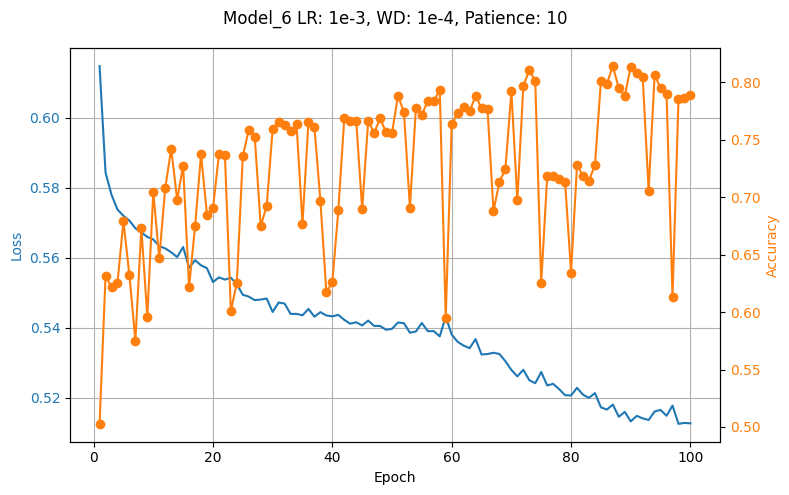


Model to test: Model_6 LR: 1e-3, WD: 5e-4, Patience: 10
feature_dim: 2048
lr=0.001 wd=0.0005 patience=10 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 16/100 loss=0.5590 val_acc=0.6694 best=0.7149:  16%|▏| 16/100 [28:04<2:26:

Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 27/100 loss=0.5508 val_acc=0.6820 best=0.7149:  27%|▎| 27/100 [47:11<2:06:

Epoch 00027: reducing learning rate of group 0 to 2.5000e-04.


Epoch 38/100 loss=0.5436 val_acc=0.6716 best=0.7149:  38%|▍| 38/100 [1:06:18<1:4

Epoch 00038: reducing learning rate of group 0 to 1.2500e-04.


Epoch 49/100 loss=0.5399 val_acc=0.6382 best=0.7149:  49%|▍| 49/100 [1:25:26<1:2

Epoch 00049: reducing learning rate of group 0 to 6.2500e-05.


Epoch 60/100 loss=0.5401 val_acc=0.6316 best=0.7149:  60%|▌| 60/100 [1:44:37<1:1

Epoch 00060: reducing learning rate of group 0 to 3.1250e-05.


Epoch 71/100 loss=0.5386 val_acc=0.6135 best=0.7149:  71%|▋| 71/100 [2:03:50<50:

Epoch 00071: reducing learning rate of group 0 to 1.5625e-05.


Epoch 82/100 loss=0.5372 val_acc=0.6069 best=0.7149:  82%|▊| 82/100 [2:23:02<31:

Epoch 00082: reducing learning rate of group 0 to 7.8125e-06.


Epoch 93/100 loss=0.5372 val_acc=0.6064 best=0.7149:  93%|▉| 93/100 [2:42:10<12:

Epoch 00093: reducing learning rate of group 0 to 3.9063e-06.


Epoch 100/100 loss=0.5360 val_acc=0.6086 best=0.7149: 100%|█| 100/100 [2:54:23<0

Best val accuracy: 0.7149122807017544


Final TEST accuracy: 0.7194719471947195


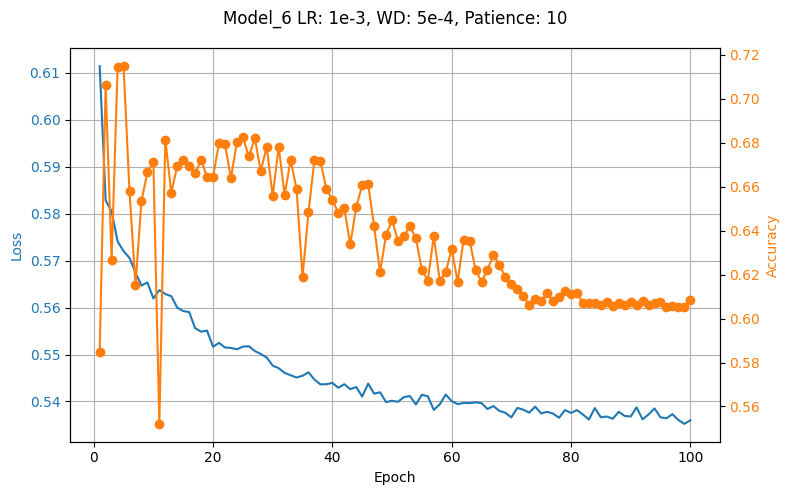


Model to test: Model_6 LR: 1e-3, WD: 0, Patience: 15
feature_dim: 2048
lr=0.001 wd=0 patience=15 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 21/100 loss=0.5564 val_acc=0.5927 best=0.7171:  21%|▏| 21/100 [36:54<2:18:

Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.


Epoch 48/100 loss=0.5424 val_acc=0.6151 best=0.7626:  48%|▍| 48/100 [1:24:27<1:3

Epoch 00048: reducing learning rate of group 0 to 2.5000e-04.


Epoch 68/100 loss=0.5369 val_acc=0.7736 best=0.7812:  68%|▋| 68/100 [1:59:44<56:

Epoch 00068: reducing learning rate of group 0 to 1.2500e-04.


Epoch 94/100 loss=0.5314 val_acc=0.7791 best=0.7834:  94%|▉| 94/100 [2:45:16<10:

Epoch 00094: reducing learning rate of group 0 to 6.2500e-05.


Epoch 100/100 loss=0.5297 val_acc=0.7812 best=0.7834: 100%|█| 100/100 [2:55:50<0

Best val accuracy: 0.7834429824561403


Final TEST accuracy: 0.7821782178217822


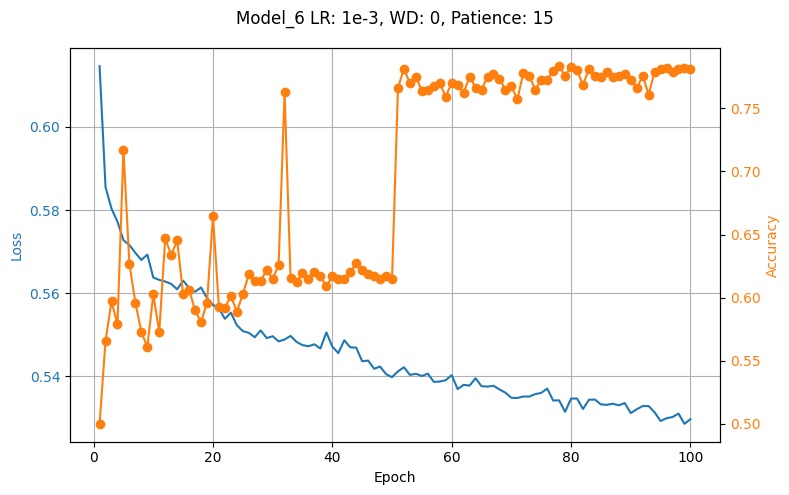


Model to test: Model_6 LR: 1e-3, WD: 1e-5, Patience: 15
feature_dim: 2048
lr=0.001 wd=1e-05 patience=15 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 21/100 loss=0.5564 val_acc=0.5927 best=0.7171:  21%|▏| 21/100 [36:58<2:18:

Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.


Epoch 48/100 loss=0.5424 val_acc=0.6151 best=0.7626:  48%|▍| 48/100 [1:24:14<1:3

Epoch 00048: reducing learning rate of group 0 to 2.5000e-04.


Epoch 68/100 loss=0.5369 val_acc=0.7736 best=0.7812:  68%|▋| 68/100 [1:59:17<55:

Epoch 00068: reducing learning rate of group 0 to 1.2500e-04.


Epoch 94/100 loss=0.5314 val_acc=0.7791 best=0.7834:  94%|▉| 94/100 [2:44:50<10:

Epoch 00094: reducing learning rate of group 0 to 6.2500e-05.


Epoch 100/100 loss=0.5297 val_acc=0.7812 best=0.7834: 100%|█| 100/100 [2:55:31<0

Best val accuracy: 0.7834429824561403


Final TEST accuracy: 0.7821782178217822


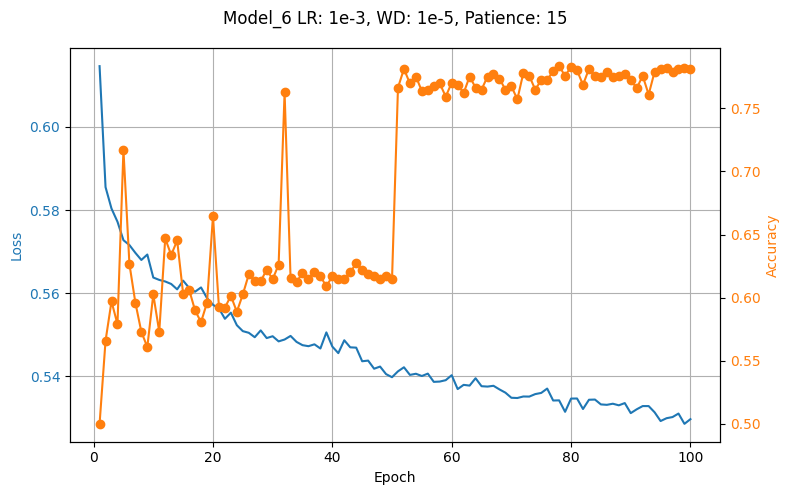


Model to test: Model_6 LR: 1e-3, WD: 5e-5, Patience: 15
feature_dim: 2048
lr=0.001 wd=5e-05 patience=15 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 30/100 loss=0.5530 val_acc=0.6151 best=0.7056:  30%|▎| 30/100 [52:45<2:02:

Epoch 00030: reducing learning rate of group 0 to 5.0000e-04.


Epoch 46/100 loss=0.5416 val_acc=0.6497 best=0.7056:  46%|▍| 46/100 [1:20:42<1:3

Epoch 00046: reducing learning rate of group 0 to 2.5000e-04.


Epoch 62/100 loss=0.5354 val_acc=0.6168 best=0.7056:  62%|▌| 62/100 [1:48:46<1:0

Epoch 00062: reducing learning rate of group 0 to 1.2500e-04.


Epoch 78/100 loss=0.5294 val_acc=0.6212 best=0.7056:  78%|▊| 78/100 [2:16:53<38:

Epoch 00078: reducing learning rate of group 0 to 6.2500e-05.


Epoch 94/100 loss=0.5293 val_acc=0.6277 best=0.7056:  94%|▉| 94/100 [2:45:00<10:

Epoch 00094: reducing learning rate of group 0 to 3.1250e-05.


Epoch 100/100 loss=0.5299 val_acc=0.6266 best=0.7056: 100%|█| 100/100 [2:55:32<0

Best val accuracy: 0.7055921052631579


Final TEST accuracy: 0.7128712871287128


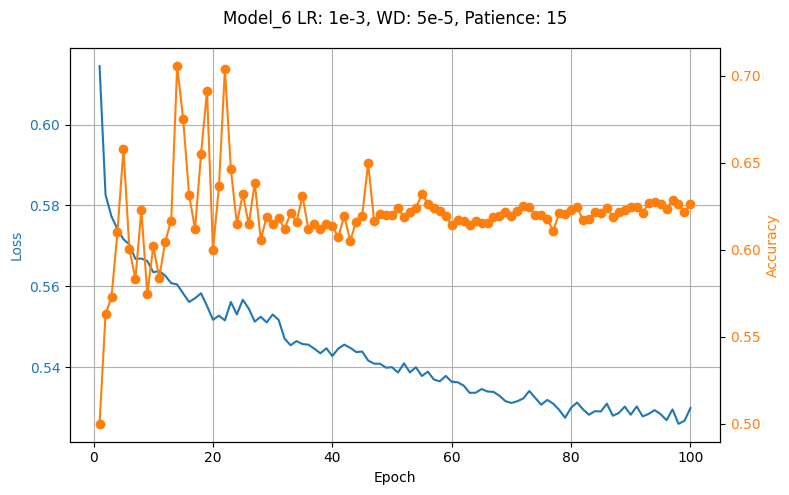


Model to test: Model_6 LR: 1e-3, WD: 1e-4, Patience: 15
feature_dim: 2048
lr=0.001 wd=0.0001 patience=15 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 54/100 loss=0.5448 val_acc=0.7473 best=0.7692:  54%|▌| 54/100 [1:34:29<1:2

Epoch 00054: reducing learning rate of group 0 to 5.0000e-04.


Epoch 100/100 loss=0.5205 val_acc=0.7648 best=0.8015: 100%|█| 100/100 [2:55:02<0

Best val accuracy: 0.8015350877192983


Final TEST accuracy: 0.8063806380638063


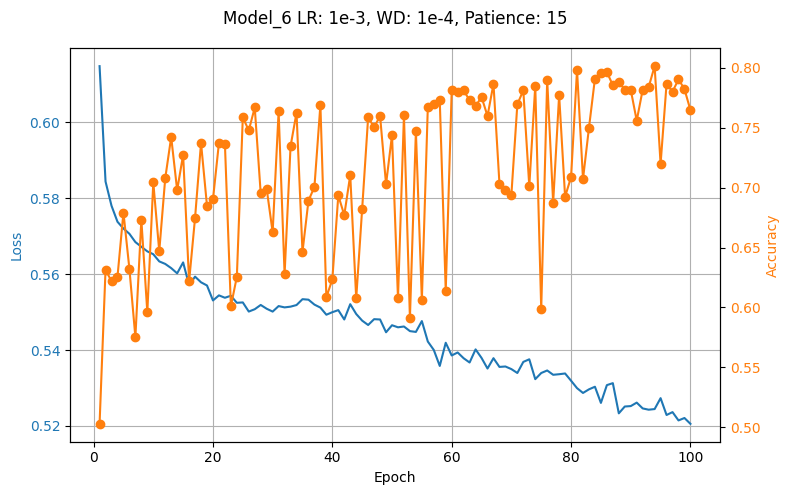


Model to test: Model_6 LR: 1e-3, WD: 5e-4, Patience: 15
feature_dim: 2048
lr=0.001 wd=0.0005 patience=15 factor=0.5 min_lr=1e-10 seed=0 batch=None


Epoch 21/100 loss=0.5587 val_acc=0.6721 best=0.7149:  21%|▏| 21/100 [37:04<2:18:

Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.


Epoch 53/100 loss=0.5418 val_acc=0.7182 best=0.7856:  53%|▌| 53/100 [1:33:15<1:2

Epoch 00053: reducing learning rate of group 0 to 2.5000e-04.


Epoch 72/100 loss=0.5348 val_acc=0.7204 best=0.7939:  72%|▋| 72/100 [2:06:37<49:

Epoch 00072: reducing learning rate of group 0 to 1.2500e-04.


Epoch 88/100 loss=0.5301 val_acc=0.7769 best=0.7939:  88%|▉| 88/100 [2:34:40<20:

Epoch 00088: reducing learning rate of group 0 to 6.2500e-05.


Epoch 100/100 loss=0.5249 val_acc=0.7363 best=0.7939: 100%|█| 100/100 [2:55:36<0

Best val accuracy: 0.793859649122807


Final TEST accuracy: 0.7953795379537953


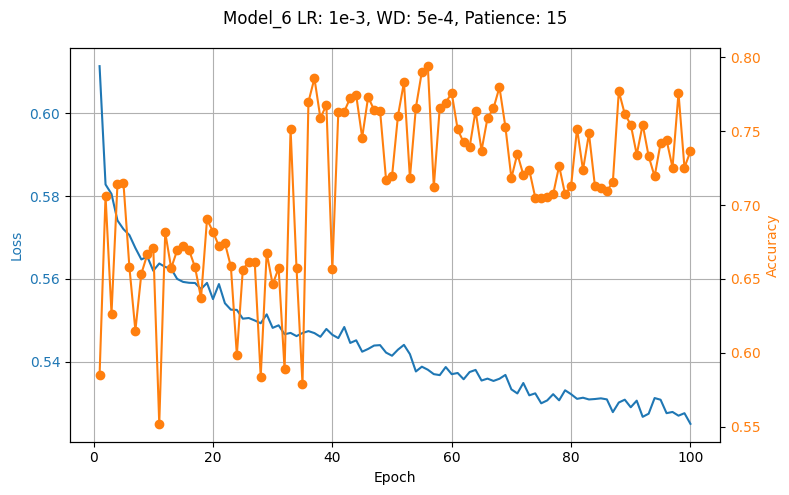

(0.793859649122807, 0.7953795379537953)

In [51]:
# run_experiment(Model8_Bottleneck1x1, "Model_8", 100)
# run_experiment(Model9_VGGLite, "Model_9", 100)
# run_experiment(Model10_MorePooling, "Model_10", 100)
# run_experiment(Model11_CappedChannels, "Model_11", 100)
# run_experiment(Model12_ShrinkBeforeFC, "Model_12", 100)
# run_experiment(Model15_2conv_stages, "Model_15", 100)
# run_experiment(Model22_extra_conv_mid, "Model_22", 100)
# run_experiment(Model14_VGGmini_morepool, "Model_14", 100)
# run_experiment(Model21_late64, "Model_21", 100)
# run_experiment(Model20_all32, "Model_20", 100)
# run_experiment(Model13_VGGmini, "Model_13", 100)
# run_experiment(Model16_wide_early, "Model_16", 100)
# run_experiment(Model17_deeper_4blocks, "Model_17", 100)
# run_experiment(Model18_bigger_head, "Model_18", 100)
# run_experiment(Model19_lowchan_deeper, "Model_19", 100)
# run_experiment(M6_1_WiderEarly, "M6_1_WiderEarly", 100)
# run_experiment(M6_2_StrongerLate, "M6_2_StrongerLate", 100)
# run_experiment(M6_3_ExtraConvMid, "M6_3_ExtraConvMid", 100)
# run_experiment(M6_4_BiggerHead, "M6_4_BiggerHead", 100)
# run_experiment(M6_5_BottleneckMid, "M6_5_BottleneckMid", 100)
# run_experiment(M13_1_ExtraConvEarly, "M13_1_ExtraConvEarly", 100)
# run_experiment(M13_2_Wider, "M13_2_Wider", 100)
# run_experiment(M13_3_Extra1x1Late, "M13_3_Extra1x1Late", 100)
# run_experiment(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC", 100)
# run_experiment(M13_5_WithDropout, "M13_5_WithDropout", 100)
# run_experiment(M19_1_SlightlyWider, "M19_1_SlightlyWider", 100)
# run_experiment(M19_2_LastTo32, "M19_2_LastTo32", 100)
# run_experiment(M19_3_ExtraConvMid, "M19_3_ExtraConvMid", 100)
# run_experiment(M19_4_BottleneckBeforeC3, "M19_4_BottleneckBeforeC3", 100)
# run_experiment(M19_5_BiggerHead, "M19_5_BiggerHead", 100)

# LR VARIATION

# run_experiment_new(Model13_VGGmini, "Model_13 1e-3", 100, lr = 1e-3)
# run_experiment(Model13_VGGmini, "Model_13 1e-3", 100)

# run_experiment_new(Model13_VGGmini, "Model_13 3e-4", 100, lr = 3e-4)
# run_experiment_new(Model13_VGGmini, "Model_13 5e-4", 100, lr = 5e-4)
# run_experiment_new(Model13_VGGmini, "Model_13 2e-3", 100, lr = 2e-3)

# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
# run_experiment(SmallKerasLikeQuantCNN, "Model_6 1e-3", 100)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 3e-4", 100, lr = 3e-4, min_lr = 1e-8)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 5e-4", 100, lr = 5e-4, min_lr = 1e-8)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 2e-3", 100, lr = 2e-3, min_lr = 1e-8)


# run_experiment_new(Model19_lowchan_deeper, "Model_19 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
# run_experiment(Model19_lowchan_deeper, "Model_19 1e-3", 100)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 3e-4", 100, lr = 3e-4, min_lr = 1e-8)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 5e-4", 100, lr = 5e-4, min_lr = 1e-8)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 2e-3", 100, lr = 2e-3, min_lr = 1e-8)


# run_experiment_new(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
# run_experiment(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 1e-3", 100)
# run_experiment_new(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 3e-4", 100, lr = 3e-4, min_lr = 1e-8)
# run_experiment_new(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 5e-4", 100, lr = 5e-4, min_lr = 1e-8)
# run_experiment_new(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 2e-3", 100, lr = 2e-3, min_lr = 1e-8)

# run_experiment_new(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
# run_experiment(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 1e-3", 100)
# run_experiment_new(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 3e-4", 100, lr = 3e-4, min_lr = 1e-8)
# run_experiment_new(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 5e-4", 100, lr = 5e-4, min_lr = 1e-8)
# run_experiment_new(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 2e-3", 100, lr = 2e-3, min_lr = 1e-8)

#### VARIATION OF OTHER PARAMETERS: WEIGHT DECAY, PATIENCE at a fixed BATCH SIZE = 16 

### KEEP THE BEST LR foreach Model 

### MODEL 13: Best LR: 1e-3 

run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 0, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 2)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-5, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 2)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-5, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 2)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-4, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 2)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-4, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 2)

run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 0, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 5)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-5, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 5)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-5, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 5)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-4, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 5)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-4, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 5)

run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 0, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 10)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-5, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 10)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-5, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 10)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-4, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 10)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-4, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 10)

run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 0, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 15)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-5, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 15)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-5, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 15)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-4, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 15)
run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-4, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 15)

### MODEL 6: Best LR: 1e-3 

run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 0, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 2)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-5, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 2)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-5, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 2)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-4, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 2)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-4, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 2)

run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 0, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 5)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-5, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 5)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-5, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 5)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-4, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 5)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-4, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 5)

run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 0, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 10)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-5, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 10)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-5, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 10)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-4, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 10)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-4, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 10)

run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 0, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 15)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-5, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 15)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-5, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 15)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-4, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 15)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-4, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 15)

# ### MODEL 19: Best LR: 2e-3 

# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 0, Patience: 2", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 0, patience = 2)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-5, Patience: 2", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 2)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-5, Patience: 2", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 2)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-4, Patience: 2", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 2)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-4, Patience: 2", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 2)

# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 0, Patience: 5", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 0, patience = 5)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-5, Patience: 5", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 5)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-5, Patience: 5", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 5)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-4, Patience: 5", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 5)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-4, Patience: 5", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 5)

# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 0, Patience: 10", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 0, patience = 10)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-5, Patience: 10", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 10)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-5, Patience: 10", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 10)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-4, Patience: 10", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 10)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-4, Patience: 10", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 10)

# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 0, Patience: 15", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 0, patience = 15)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-5, Patience: 15", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 15)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-5, Patience: 15", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 15)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-4, Patience: 15", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 15)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-4, Patience: 15", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 15)

# ### MODEL 13_3: Best LR: 5e-4 

# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 0, Patience: 2", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 0, patience = 2)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-5, Patience: 2", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-5, patience = 2)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-5, Patience: 2", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-5, patience = 2)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-4, Patience: 2", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-4, patience = 2)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-4, Patience: 2", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-4, patience = 2)

# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 0, Patience: 5", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 0, patience = 5)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-5, Patience: 5", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-5, patience = 5)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-5, Patience: 5", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-5, patience = 5)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-4, Patience: 5", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-4, patience = 5)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-4, Patience: 5", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-4, patience = 5)

# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 0, Patience: 10", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 0, patience = 10)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-5, Patience: 10", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-5, patience = 10)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-5, Patience: 10", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-5, patience = 10)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-4, Patience: 10", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-4, patience = 10)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-4, Patience: 10", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-4, patience = 10)

# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 0, Patience: 15", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 0, patience = 15)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-5, Patience: 15", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-5, patience = 15)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-5, Patience: 15", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-5, patience = 15)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-4, Patience: 15", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-4, patience = 15)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-4, Patience: 15", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-4, patience = 15)

# ### MODEL 13_4: Best LR: 1e-3 

# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 0, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 2)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-5, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 2)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-5, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 2)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-4, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 2)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-4, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 2)

# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 0, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 5)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-5, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 5)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-5, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 5)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-4, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 5)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-4, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 5)

# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 0, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 10)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-5, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 10)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-5, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 10)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-4, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 10)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-4, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 10)

# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 0, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 15)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-5, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 15)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-5, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 15)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-4, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 15)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-4, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 15)




